# 0.0. Imports


In [1]:
# Blibliotecas

import pandas  as pd
import numpy   as np
import seaborn as sns 
import xgboost as xgb
import inflection
import math
import datetime
import random
import warnings
import pickle

from boruta                import BorutaPy
from matplotlib            import pyplot as plt
from matplotlib.gridspec   import GridSpec
from IPython.display       import Image
from tabulate              import tabulate
from scipy                 import stats
from IPython.core.display  import HTML

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso

warnings.filterwarnings( 'ignore' )

### 0.1 Helper Functions

In [2]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):

    mae_list  = []
    mape_list = []
    rmse_list = []

    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )

        #start and end date for validation
        validation_start_date = x_training[ 'date' ].max() - datetime.timedelta( days=k*6*7 )
        validation_end_date   = x_training[ 'date' ].max() - datetime.timedelta( days=(k-1)*6*7 )

        # filtering dataset
        training   = x_training[ x_training[ 'date' ] < validation_start_date ]
        validation = x_training[(x_training[ 'date' ] >= validation_start_date ) & ( x_training[ 'date'] <= validation_end_date)]

        # training and validation dataset
        xtraining = training.drop( [ 'date', 'sales' ],axis=1 )
        ytraining = training[ 'sales' ]

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation[ 'sales' ]

        # Model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # Preformance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iterention
        mae_list.append(  m_result[ 'MAE'  ] )
        mape_list.append( m_result[ 'MAPE' ] )
        rmse_list.append( m_result[ 'RMSE' ] )

    return pd.DataFrame({
                        'Model Name':  model_name,
        
                        'MAE CV': np.round( np.mean( mae_list ), 2).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2).astype( str ),
                        'MAPE CV': np.round( np.mean( mape_list ), 2).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2).astype( str ),
                        'RMSE CV': np.round( np.mean( rmse_list ), 2).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2).astype( str ) }, index=[0] )


def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )
     
    
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

    
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2 / (n-1)
    rcorr = r - (r-1)**2 / (n-1)
    return np.sqrt( (chi2/n) / (min( kcorr-1, rcorr-1 ) ) )


sns.set(rc={'figure.figsize':(25,12)})


def jupyter_settings():
    %matpoltlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style> ' ) )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False )
    
    sns.set()

### 0.2. Loading data

In [3]:
df_sales_raw = pd.read_csv('datasets/train.csv', low_memory=False )
df_store_raw = pd.read_csv('datasets/store.csv', low_memory=False )

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

### Legenda Colunas


    'Store' - Lojas ativas
    'DayOfWeek' - Dias da semana
    'Date' - Dias
    'Sales' - Vendas
    'Customers' - Clientes por loja
    'Open' - Loja esta aberta ou fechada
    'Promo' - Lojas com promocoes ativas
    'StateHoliday' - Feriados nacionais
    'SchoolHoliday' - Feriados escolares (Ferias escolares)
    'StoreType' - Tipo de loja
    'Assortment' - Sortimento da loja
    'CompetitionDistance' - Distancia das lojas - competidoras
    'CompetitionOpenSinceMonth', - Loja com promocao desde - Mensal
    'CompetitionOpenSinceYear'  - lojas com promocao desde - Anual
    'Promo2' - Lojas com continuacao da PROMO
    'Promo2SinceWeek', - Data da promo2 semanal
    'Promo2SinceYear' - Data da Promo2 Anual
    'PromoInterval - Intervalo de promocoes

# 1.0. PASSO 1 - Descrição dos dados

In [4]:
df1 = df_raw.copy() #Copia dos dados para DF1

## 1.1. Rename Columns

In [5]:
cols_old = ['Store',
            'DayOfWeek',
            'Date',
            'Sales', 
            'Customers',
            'Open',
            'Promo',
            'StateHoliday',
            'SchoolHoliday',
            'StoreType',
            'Assortment',
            'CompetitionDistance',
            'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear',
            'Promo2',
            'Promo2SinceWeek',
            'Promo2SinceYear',
            'PromoInterval' ]

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# rename
df1.columns = cols_new

## 1.2. Data dimensions

In [8]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) ) # Numero de linhas
print( 'Number of Cols: {}'.format( df1.shape[1] ) ) # Numero de colunas 

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data types

In [9]:
df1['date'] = pd.to_datetime( df1['date'] ) # Transformacao do tipo da coluna - No caso 'Date'
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [10]:
df1.isna().sum() # Check isna

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [11]:
#vericar quantas linhas tem a coluna abaxo usando max_value
df1['competition_distance'].max() 

75860.0

## 1.5. Fillout NA

In [13]:
# Removendo NA usando lambda

# competition_distance
df1[ 'competition_distance' ] = df1[ 'competition_distance' ].apply( lambda x: 200000.0 if math.isnan( x ) else x )
# competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis=1 )
# competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'], axis=1 )
# promo2_since_week             
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'], axis=1 )
# promo2_since_year         
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'], axis=1 )
# promo_interval


In [14]:
# Criando uma Coluna Mes, e substituindo NA por 0
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dez'}

df1['promo_interval'].fillna(0, inplace=True ) #Foi substituido NA por 0, nao retornando nenhum valor

df1['month_map'] = df1['date'].dt.month.map( month_map ) #Transforma em data / mes / depois substitui os numeros por letras

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1 )


## 1.6. Change Types

In [15]:
# Modificando o tipo dos dados por colunas
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year' ] = df1['competition_open_since_year' ].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7. Descriptive Statistical

In [16]:
## 1.7.1 Numerical Attributes / Selecao de atributos 

num_attributes = df1.select_dtypes(include = ['int64','float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

In [17]:
# Central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T # Desvio padrao
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate

m = pd.concat( [ d2 , d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]

In [15]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


## 1.7.2 Categorical Attributes

In [18]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

In [17]:
cat_attributes.dtypes

state_holiday     object
store_type        object
assortment        object
promo_interval    object
month_map         object
dtype: object

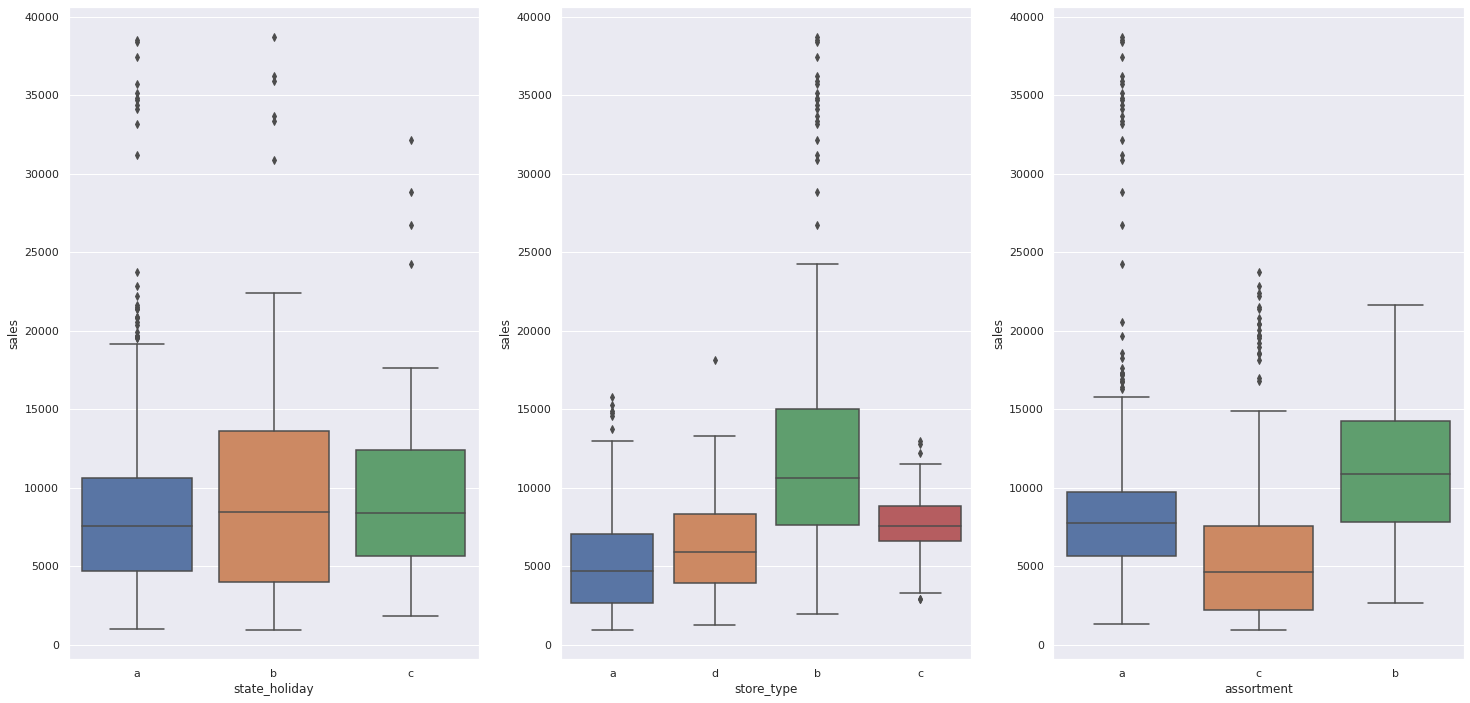

In [18]:
aux1 = df1[(df1['state_holiday'] !='0' ) & (df1['sales'] > 0)]

plt.subplot(1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data = aux1 )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data = aux1 )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data = aux1 )

df1.to_csv('store_sales_prediction')

In [19]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


# 2.0. PASSO 2 - Feature Engineering

In [19]:
#copy
df2 = df1.copy()
# df2 = pd.read_csv('store_sales_prediction',low_memory=False)

### Mapa mental de Hipotese

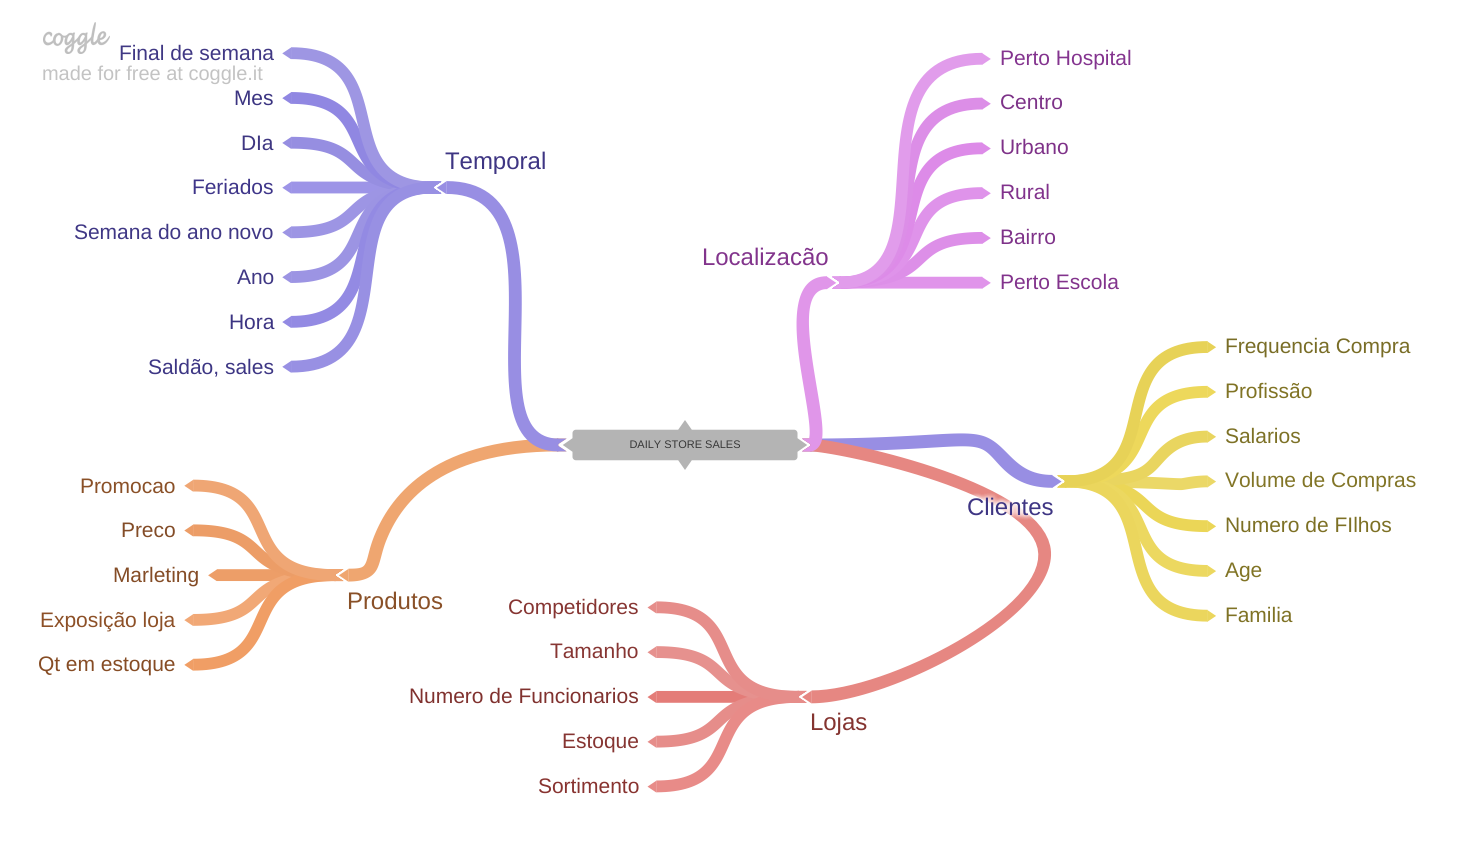

In [21]:
Image('DAILY_STORE_SALES.png')

## 2.1. Criacao das hipotese

### 2.1.1. Hipoteses Loja

**1,** Lojas com maior quadro de funcionarios deveriam vender mais.

**2,** Lojas com maior estoque deveriam vender mais.

**3,** Lojas com maior porte deveriam vender mais.

**4,** Lojas com maior sortimentos deveriam vender mais.

**5,** Lojas com competidores mais proximos deveriam vender menos.

**6,** Lojas com competidores a mais tempo deveriam vender mais.

### 2.1.2. Hipotese Produto

**1,** Lojas que investem mais em Markentig deveriam vender mais.

**2,** Lojas que expoem mais o produto na vitrine deveriam vender mais.

**3,** Lojas que tem precos menores nos produtos deveriam vender mais.

**4,** Lojas que ter precos menores por mais tempo nos produtos deveriam vender mais

**5,** Lojas com promocoes mais agressivas (descontos maiores), deveriam vender mais.

**6,** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**7,** Lojas com mais dias de promocao, deveriam vender mais.

**8,** Lojas com mais promocoes consecutivas deveriam vender mais.

### 2.1.3. Hipotese Tempo (Sazonalidade)

**1,** Lojas abertas durante o feriado de Natal, deveriam vender mais.

**2,** Lojas deveriam vender mais ao longo dos anos.

**3,** Lojas deveriam vender mais no segundo semestre do ano.

**4,** Lojas deveriam vender mais depois do dia 10 de cada mes.

**5,** Lojas deveriam vender menos aos finais de semana.

**6,** Lojas deveriam vender menos durante os feriados escolares.

## 2.2. Lista final de Hipoteses


**1,** Lojas com maior sortimentos deveriam vender mais.

**2,** Lojas com competidores mais proximos deveriam vender menos.

**3,** Lojas com competidores a mais tempo deveriam vender mais.

**4,** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**5,** Lojas com mais dias de promocao, deveriam vender mais.

**6,** Lojas com mais promocoes consecutivas deveriam vender mais.

**7,** Lojas abertas durante o feriado de Natal, deveriam vender mais.

**8,** Lojas deveriam vender mais ao longo dos anos.

**9,** Lojas deveriam vender mais no segundo semestre do ano.

**10,** Lojas deveriam vender mais depois do dia 10 de cada mes.

**11,** Lojas deveriam vender menos aos finais de semana.

**12,** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Feature Engineering

In [20]:
#year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# week year
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )


# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days ).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = (( df2['date'] - df2['promo_since']) /7).apply( lambda x: x.days ).astype( int )

# assortment
# a = basic, b = extra, c = extended
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
# a = public_holiday, b = easter_holiday, c = christmas
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [22]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. PASSO 3 - Filtragem de variaveis

In [21]:
df3 = df2.copy()

In [24]:
df3.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## 3.1. Filtragem das linhas

In [22]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Selecao das colunas


In [23]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

In [27]:
df3.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


# 4.0. PASSO 4 - Analise exploratoria dos dados

In [24]:
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1. Response Variable

<AxesSubplot:xlabel='sales', ylabel='Density'>

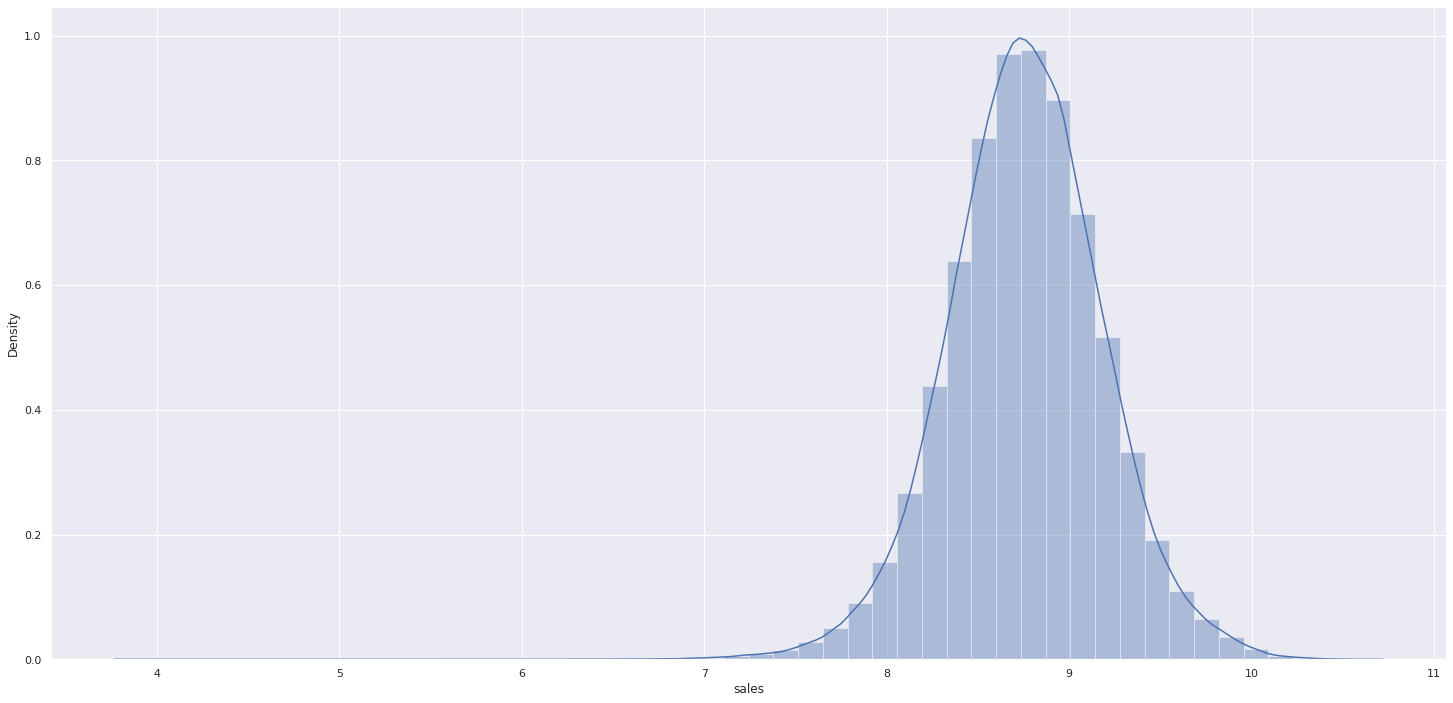

In [25]:
sns.distplot(np.log1p( df4['sales']))
# sns.distplot( df4['sales'])

### 4.1.2. Numerical Variable

array([[<AxesSubplot:title={'center':'store'}>,
        <AxesSubplot:title={'center':'day_of_week'}>,
        <AxesSubplot:title={'center':'sales'}>,
        <AxesSubplot:title={'center':'customers'}>],
       [<AxesSubplot:title={'center':'open'}>,
        <AxesSubplot:title={'center':'promo'}>,
        <AxesSubplot:title={'center':'school_holiday'}>,
        <AxesSubplot:title={'center':'competition_distance'}>],
       [<AxesSubplot:title={'center':'competition_open_since_month'}>,
        <AxesSubplot:title={'center':'competition_open_since_year'}>,
        <AxesSubplot:title={'center':'promo2'}>,
        <AxesSubplot:title={'center':'promo2_since_week'}>],
       [<AxesSubplot:title={'center':'promo2_since_year'}>,
        <AxesSubplot:title={'center':'is_promo'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

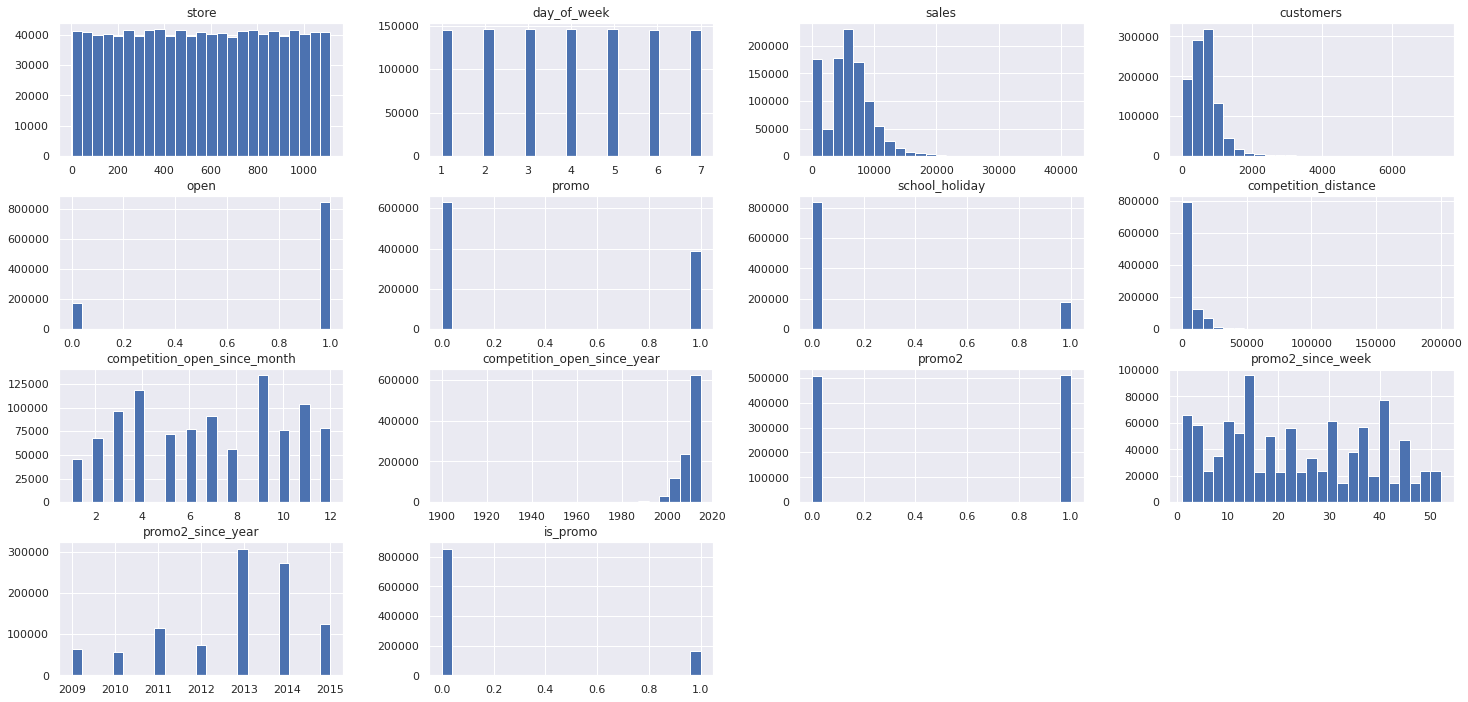

In [31]:
num_attributes.hist( bins=25 )

### 4.1.3. Categorical Variable

In [26]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

<AxesSubplot:xlabel='sales', ylabel='Density'>

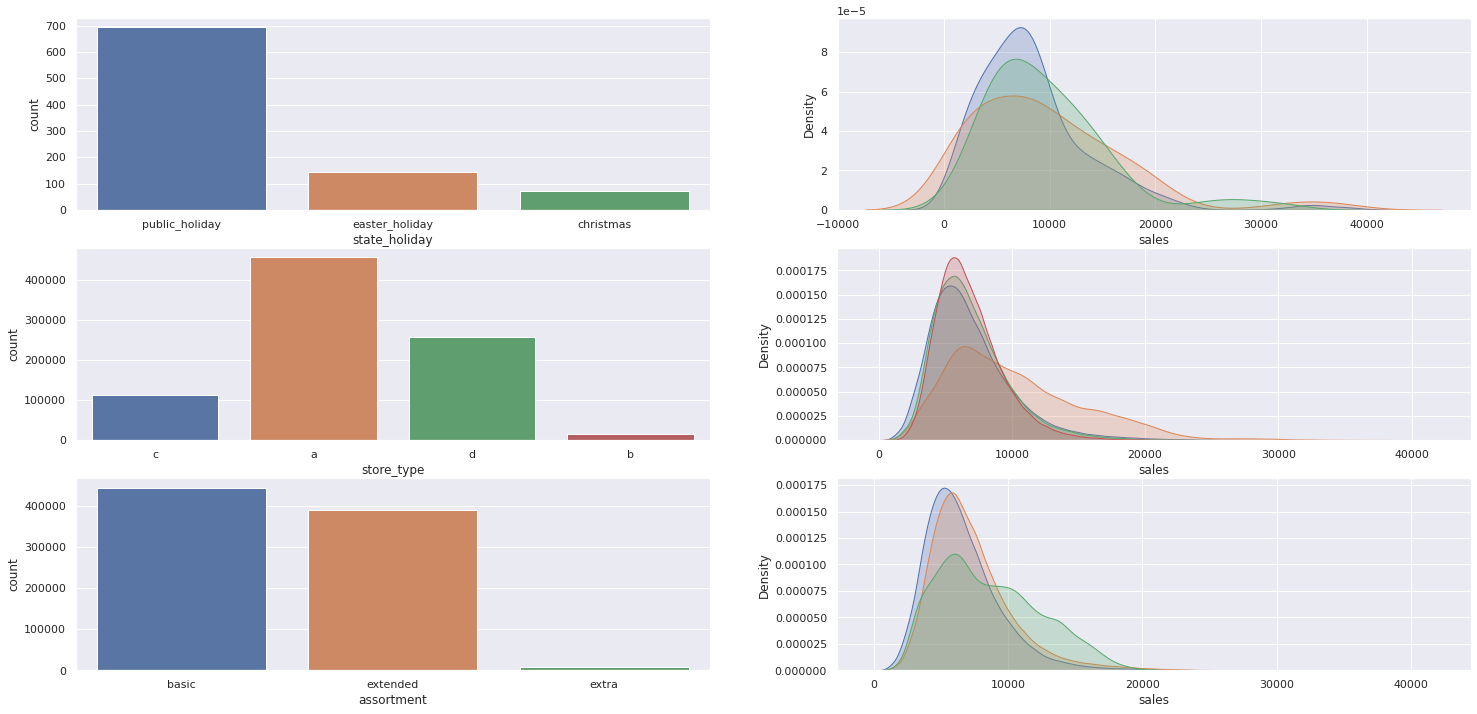

In [33]:
# state_holiday
plt.subplot( 3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot( 3, 2, 2)
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas'     ]['sales'], label='christmas'     , shade=True )
# store_type
plt.subplot( 3, 2, 3)
sns.countplot( df4['store_type'] )

plt.subplot( 3, 2, 4)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

# assortment
plt.subplot( 3, 2, 5)
sns.countplot( df4['assortment'] )

plt.subplot( 3, 2, 6)
sns.kdeplot( df4[df4['assortment'] == 'basic'   ]['sales'], label='basic'   , shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra'   ]['sales'], label='extra'   , shade=True )

## 4.2. Analise Bivariada

### H1. Lojas com maior sortimentos deveriam vender mais.
* FALSA Lojas com MAIOR SORTIMENTO vendem MENOS.



<AxesSubplot:xlabel='year_week'>

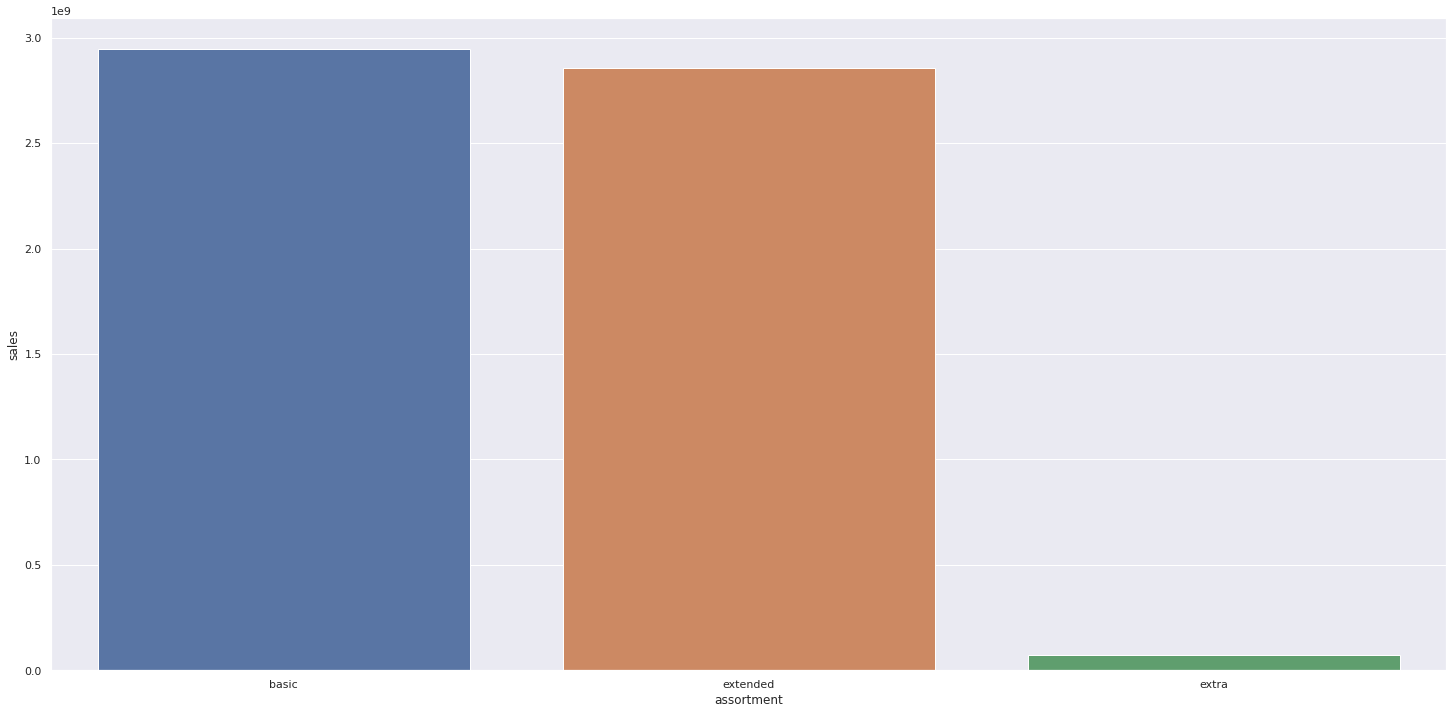

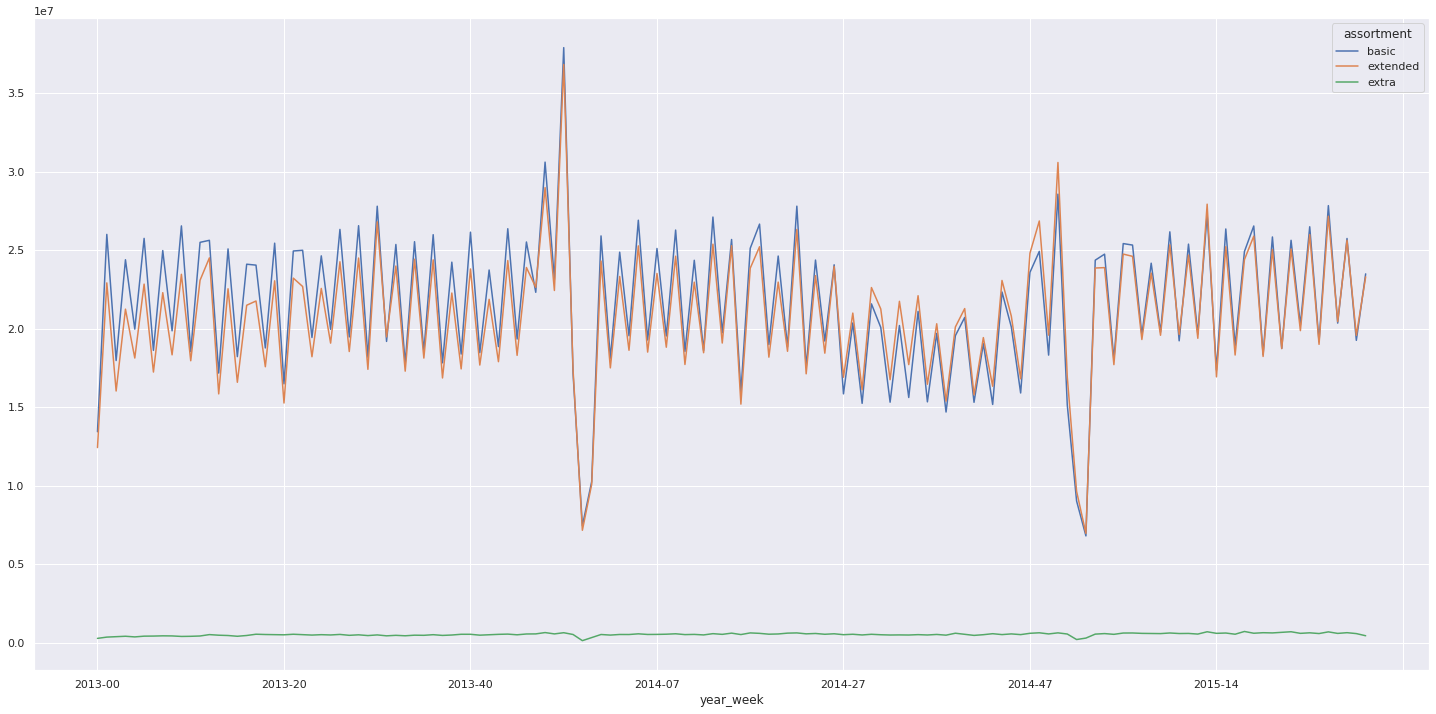

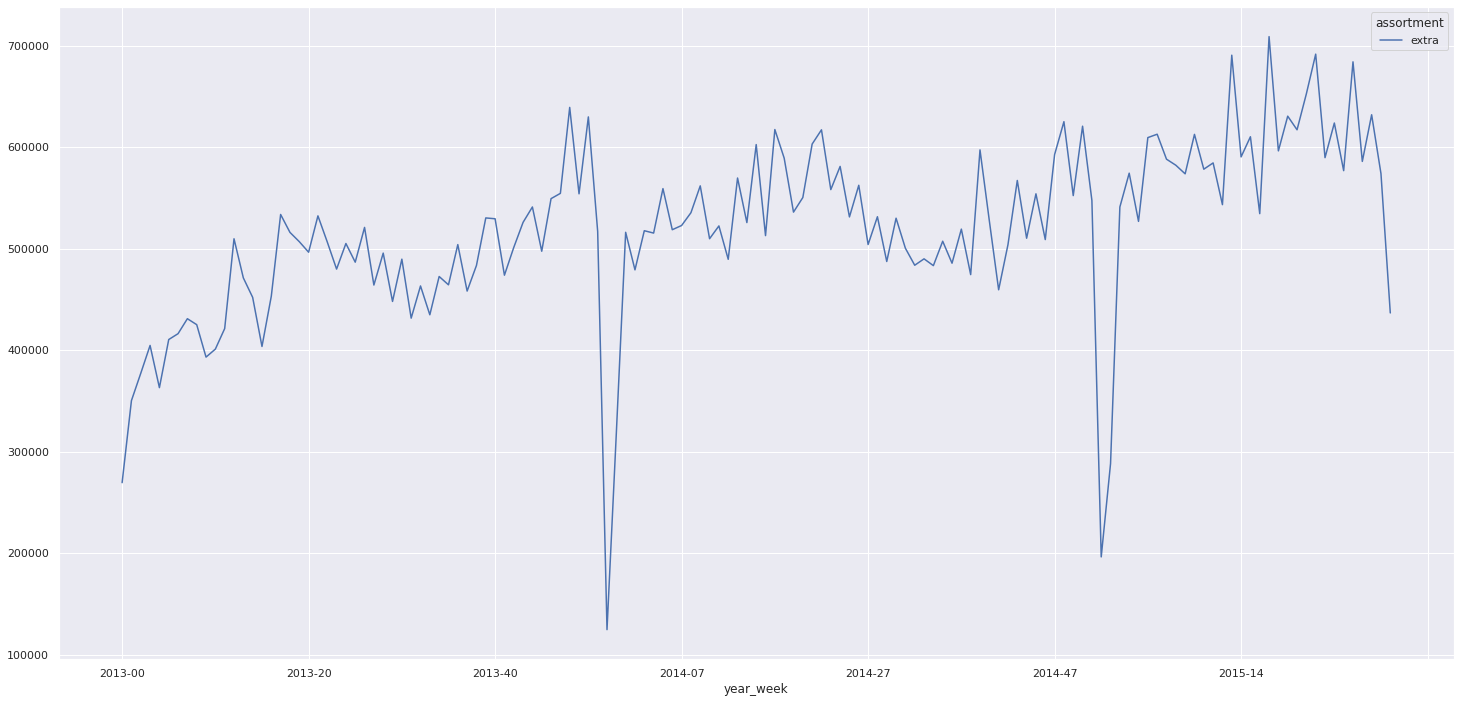

In [34]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot( index ='year_week' , columns ='assortment' , values ='sales').plot()

aux3 = aux2[ aux2[ 'assortment' ] == 'extra']
aux3.pivot( index ='year_week' , columns ='assortment' , values ='sales').plot()


### H2. Lojas com competidores mais proximos deveriam vender menos.
* Falsa - Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS.

<AxesSubplot:>

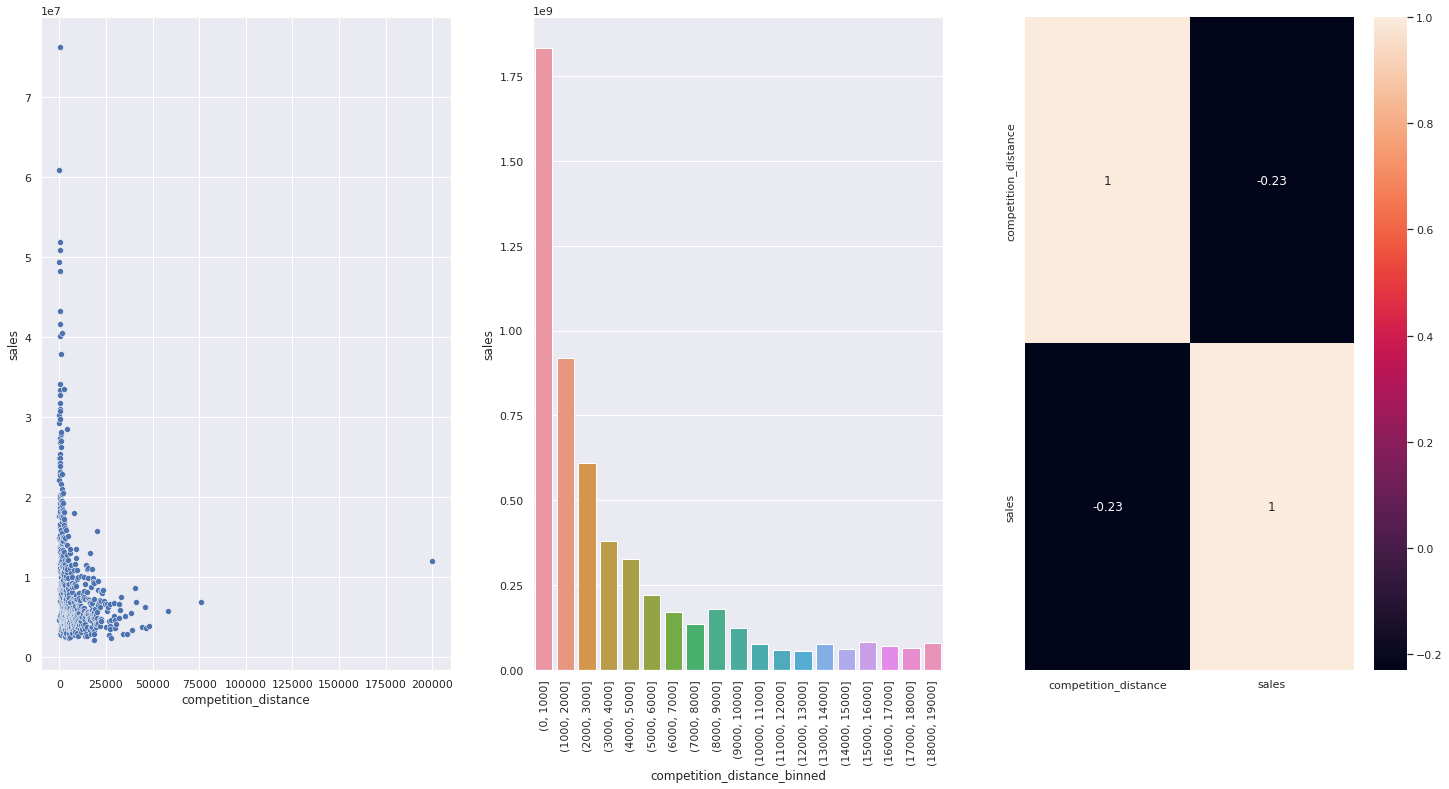

In [35]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.scatterplot( x = 'competition_distance', y = 'sales', data = aux1 );

plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut( aux1[ 'competition_distance' ], bins = bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot( x = 'competition_distance_binned' , y = 'sales' , data = aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method= 'pearson' ), annot=True )

### H3. Lojas com competidores a mais tempo deveriam vender mais.
* Falsa * Lojas com COMPETIDORES a mais tempo VENDEM MENOS

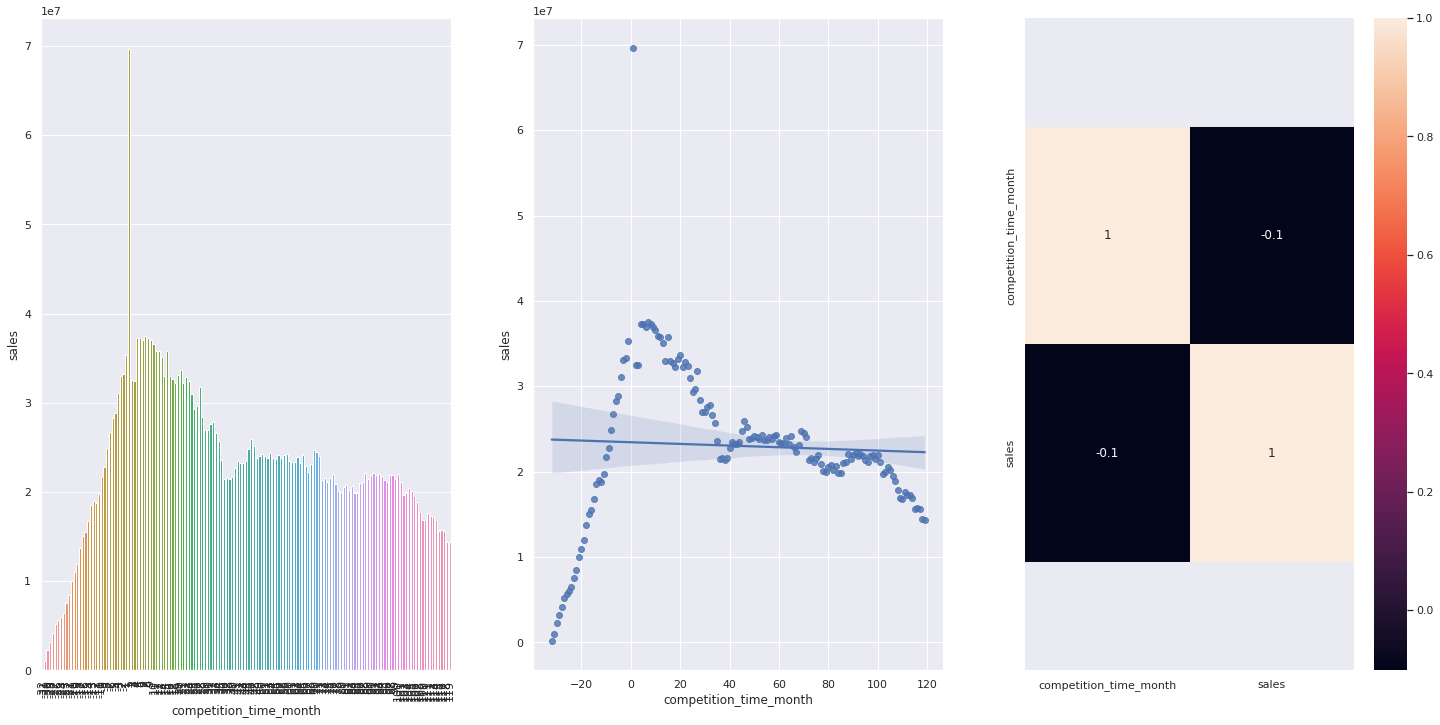

In [36]:
plt.subplot(1, 3, 1)
aux1 = df4[[ 'competition_time_month', 'sales' ]].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]
sns.barplot( x = 'competition_time_month', y = 'sales', data = aux2 );
plt.xticks( rotation = 90 );

plt.subplot(1, 3, 2)
sns.regplot( x = 'competition_time_month', y = 'sales', data = aux2 );

plt.subplot(1, 3, 3)
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

### H4. Lojas com promocoes ativas por mais tempo deveriam vender mais.
    * Falsa ** Lojas com promocoes ativas por mais tempo VENDE MENOS, depois de certo periodo de promocoes


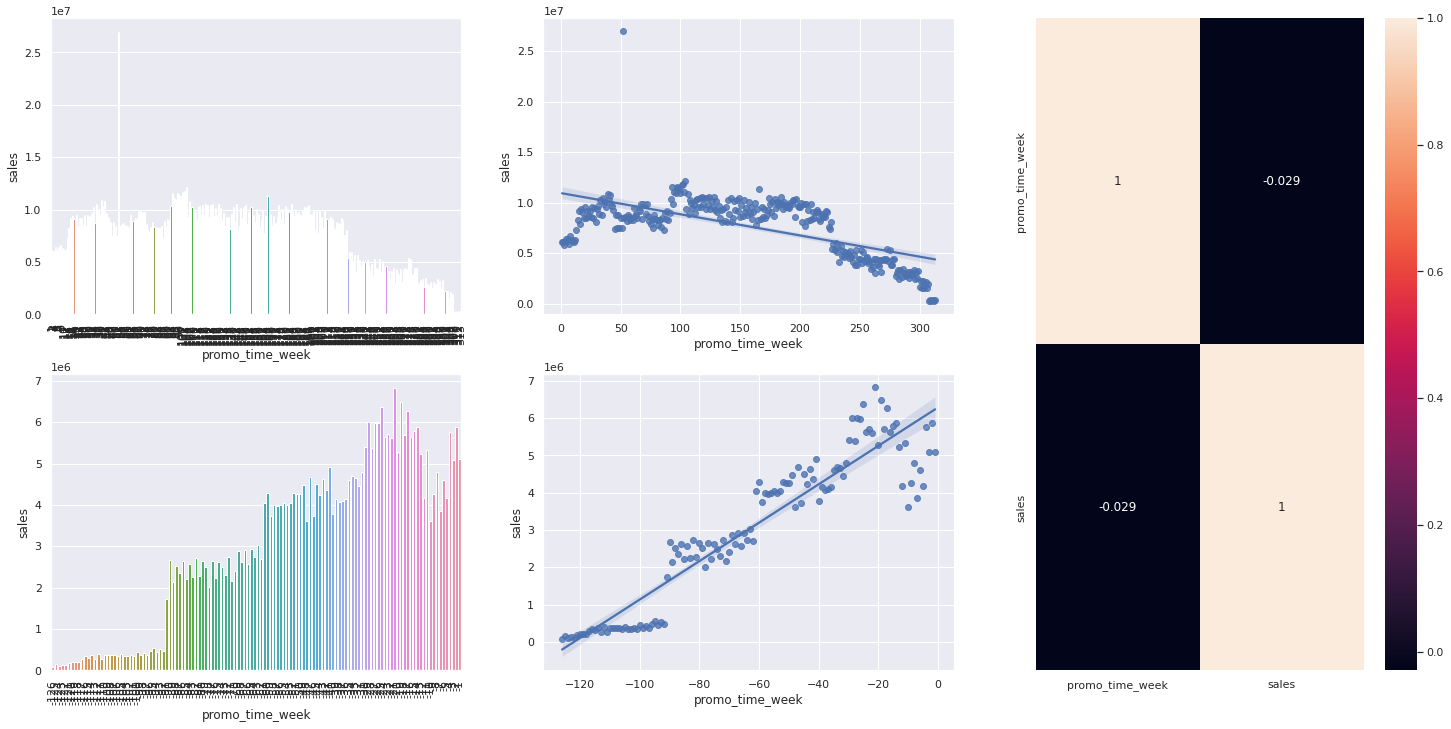

In [37]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2, 3)

plt.subplot( grid[0, 0] )
aux2 = aux1[aux1['promo_time_week'] > 0 ] #Promo extendido
sns.barplot( x = 'promo_time_week', y = 'sales', data = aux2 );
plt.xticks( rotation = 90 );

plt.subplot( grid[0,1] )
sns.regplot( x = 'promo_time_week', y = 'sales', data = aux2 );


plt.subplot( grid[1, 0] )
aux3 = aux1[aux1['promo_time_week'] < 0 ] #Promo regular
sns.barplot( x = 'promo_time_week', y = 'sales', data = aux3);
plt.xticks( rotation = 90 );

plt.subplot( grid[1, 1])
sns.regplot( x = 'promo_time_week', y = 'sales', data = aux3 );

plt.subplot( grid[:,2])
sns.heatmap( aux1.corr( method='pearson' ), annot=True );



### <s> H5. Lojas com mais dias de promocao, deveriam vender mais.</s>


### H6. Lojas com mais promocoes consecutivas deveriam vender mais.
* Falsa ** Lojas com mais promocoes consecutivas vendem menos

In [27]:
# H6
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


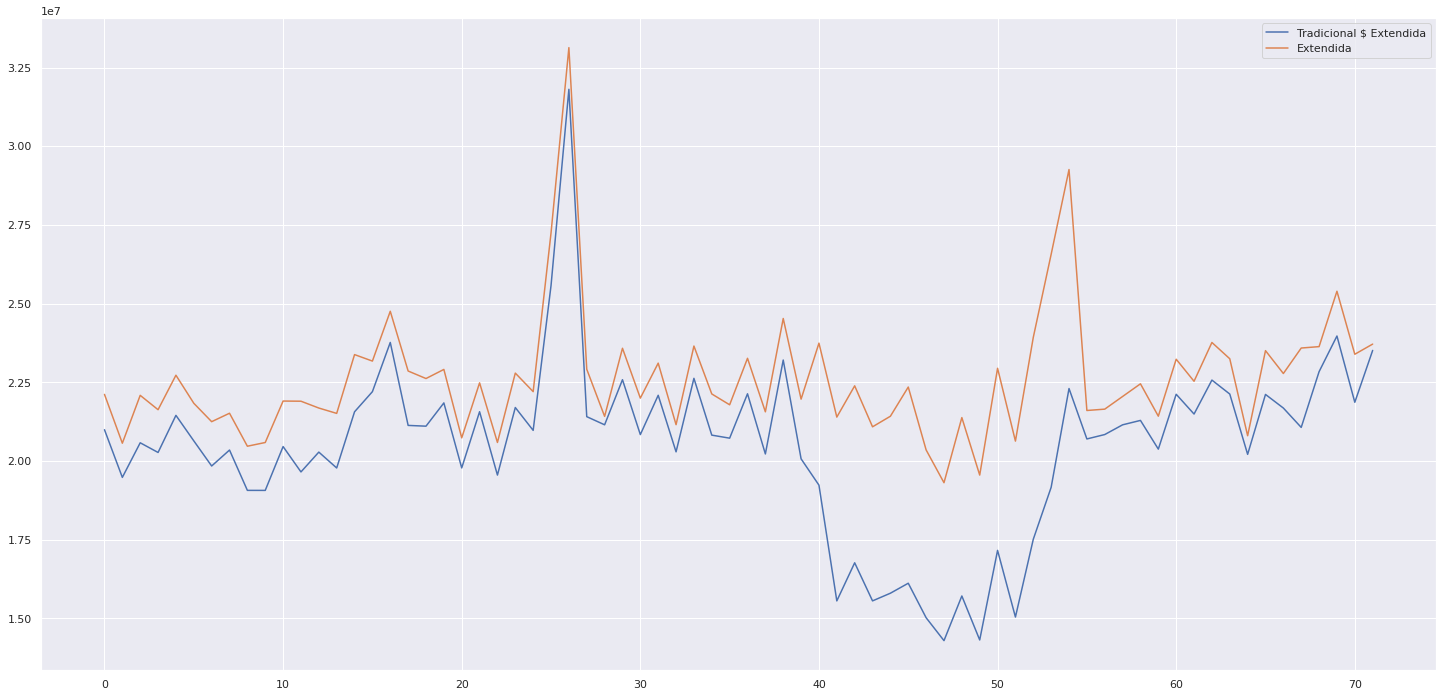

In [28]:
aux1 = df4[( df4[ 'promo' ] == 1 ) & ( df4[ 'promo2' ] == 1 )][[ 'year_week', 'sales' ]].groupby('year_week').sum().reset_index()
ax = aux1.plot()

# plt.subplot( 2, 1, 2 )
aux2 = df4[( df4[ 'promo' ] == 1 ) & ( df4[ 'promo2' ] == 0 )][[ 'year_week', 'sales' ]].groupby('year_week').sum().reset_index()
aux2.plot( ax = ax )

ax.legend( labels=['Tradicional $ Extendida', 'Extendida']);

### H7. Lojas abertas durante o feriado de Natal, deveriam vender mais.
** Falsa * Lojas abertada durante o Natal VENDEM MENOS


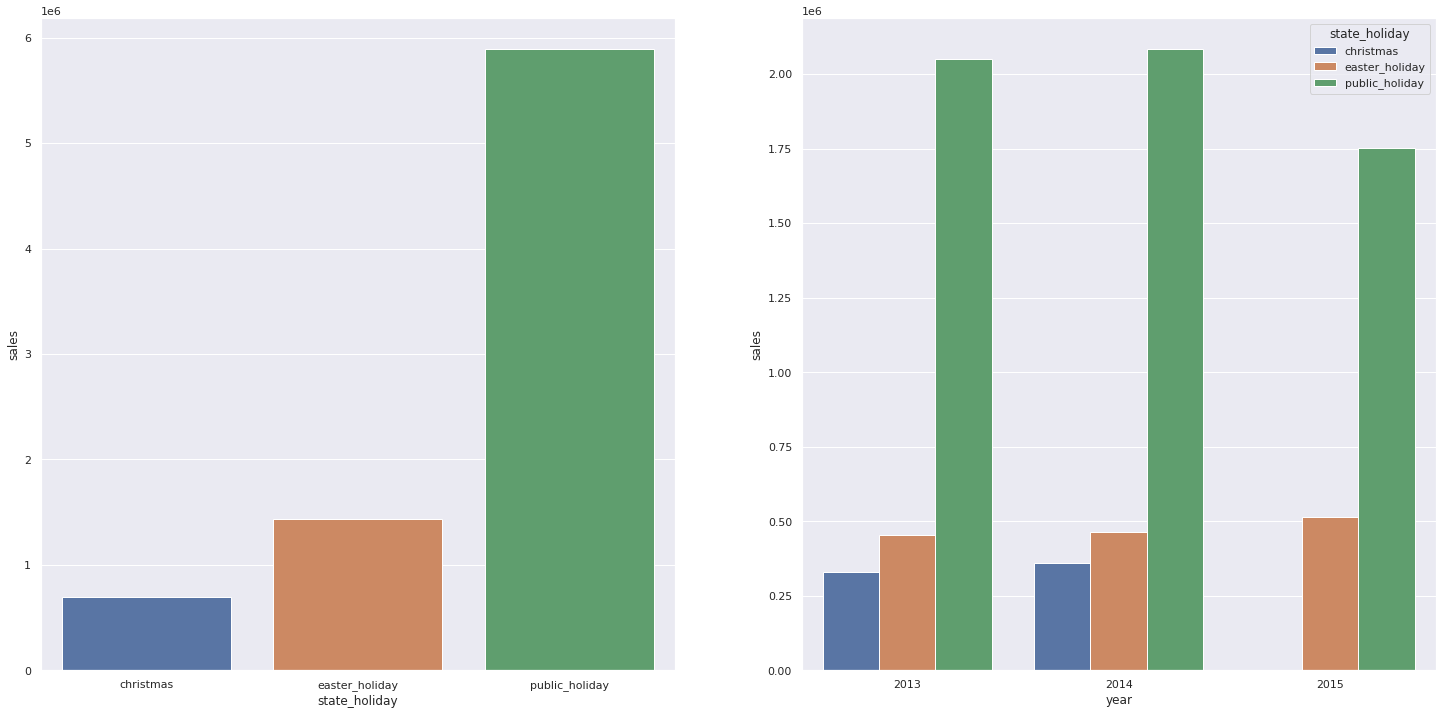

In [30]:
aux = df4[df4[ 'state_holiday' ] != 'regular_day' ]

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x = 'state_holiday', y = 'sales', data = aux1);

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot( x = 'year', y = 'sales', hue = 'state_holiday', data = aux2 );

In [31]:
aux1.head()

,state_holiday,sales
0,christmas,691806
1,easter_holiday,1433744
2,public_holiday,5890305


### H8. Lojas deveriam vender mais ao longo dos anos.
* Falsa - Lojas vendem menos ao longo dos anos


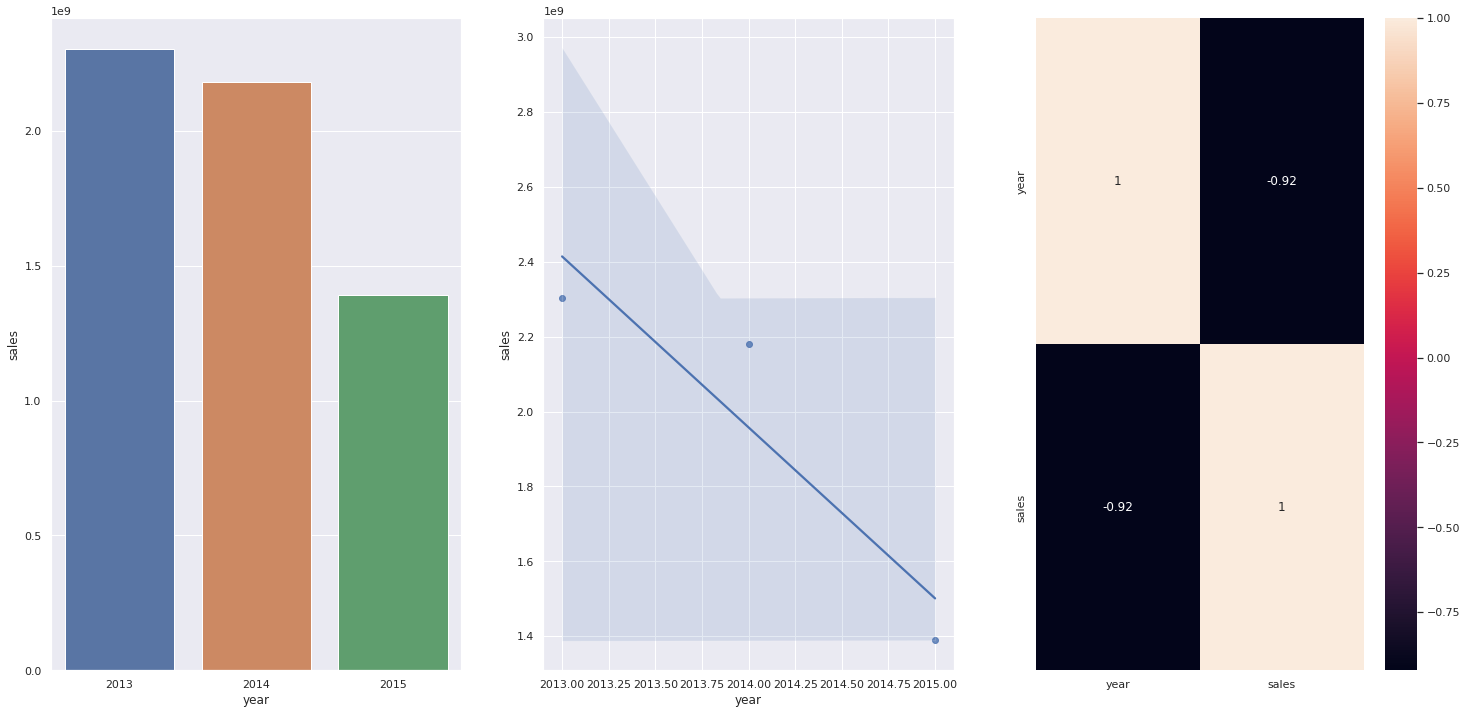

In [32]:
aux1 = df4[[ 'year', 'sales' ]].groupby( 'year' ).sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot( x = 'year', y = 'sales', data = aux1 );

plt.subplot(1, 3, 2)
sns.regplot( x = 'year', y = 'sales', data = aux1 );

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr( method='pearson' ),annot=True );




### H9. Lojas deveriam vender mais no segundo semestre do ano.
** Falsa ** Lojas vendem MENOS no segundo semestre do ano.


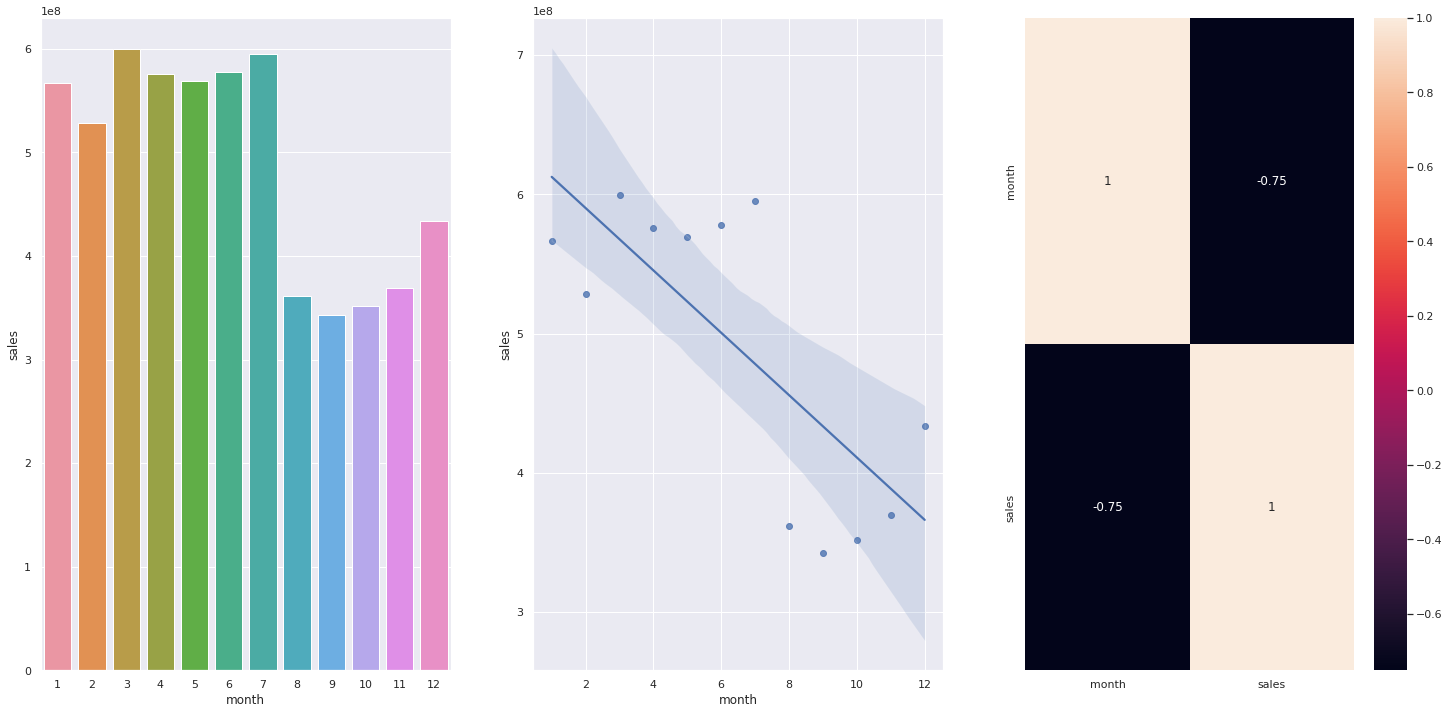

In [33]:
aux1 = df4[[ 'month', 'sales' ]].groupby( 'month' ).sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot( x = 'month', y = 'sales', data = aux1 );

plt.subplot(1, 3, 2)
sns.regplot( x = 'month', y = 'sales', data = aux1 );

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr( method='pearson' ),annot=True );

### H10. Lojas deveriam vender mais depois do dia 10 de cada mes.
* Verdadeira ** Lojas vendem MAIS depois do dia 10



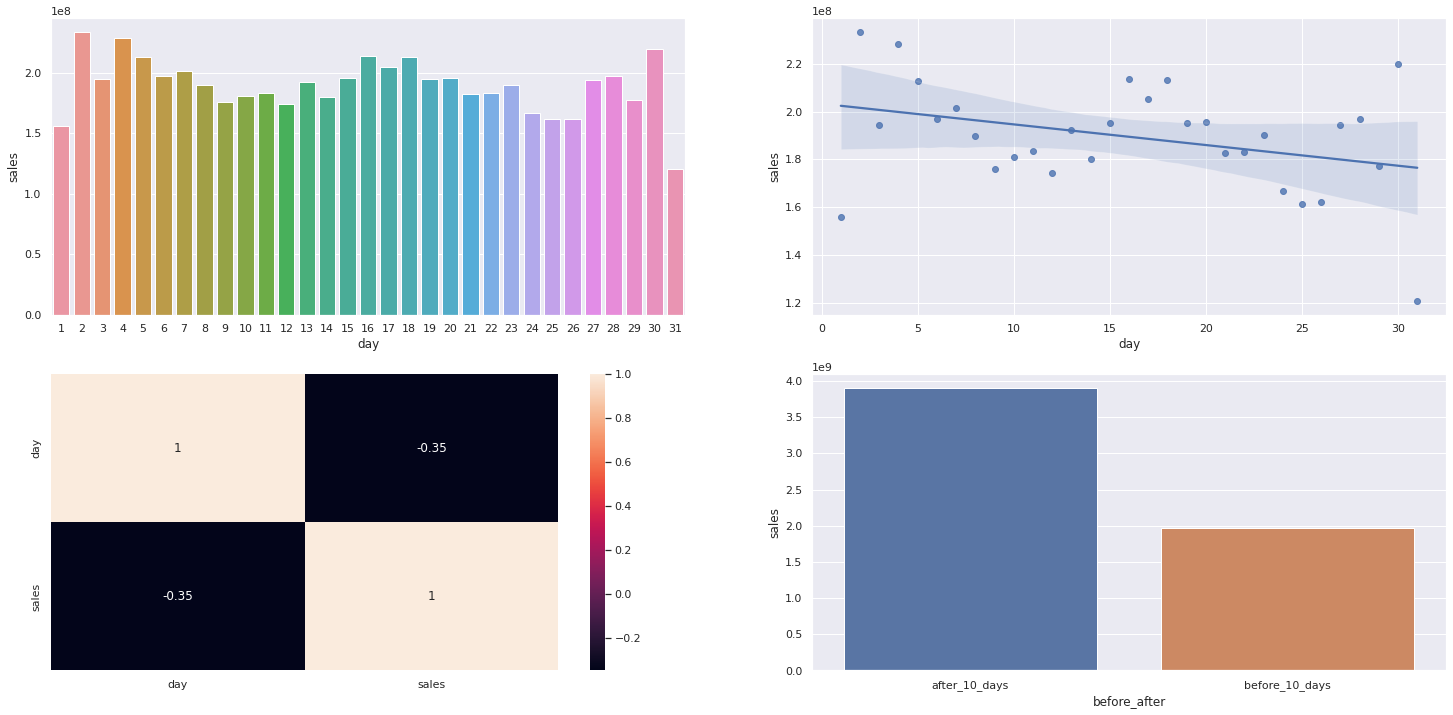

In [34]:
aux1 = df4[[ 'day', 'sales' ]].groupby( 'day' ).sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot( x = 'day', y = 'sales', data = aux1 );

plt.subplot(2, 2, 2)
sns.regplot( x = 'day', y = 'sales', data = aux1 );

plt.subplot(2, 2, 3)
sns.heatmap( aux1.corr( method='pearson' ),annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot(2, 2, 4)
sns.barplot( x = 'before_after', y = 'sales', data = aux2 );

### H11. Lojas deveriam vender menos aos finais de semana.
* Verdadeira ** Lojas vendem MENOS nos finais de semana


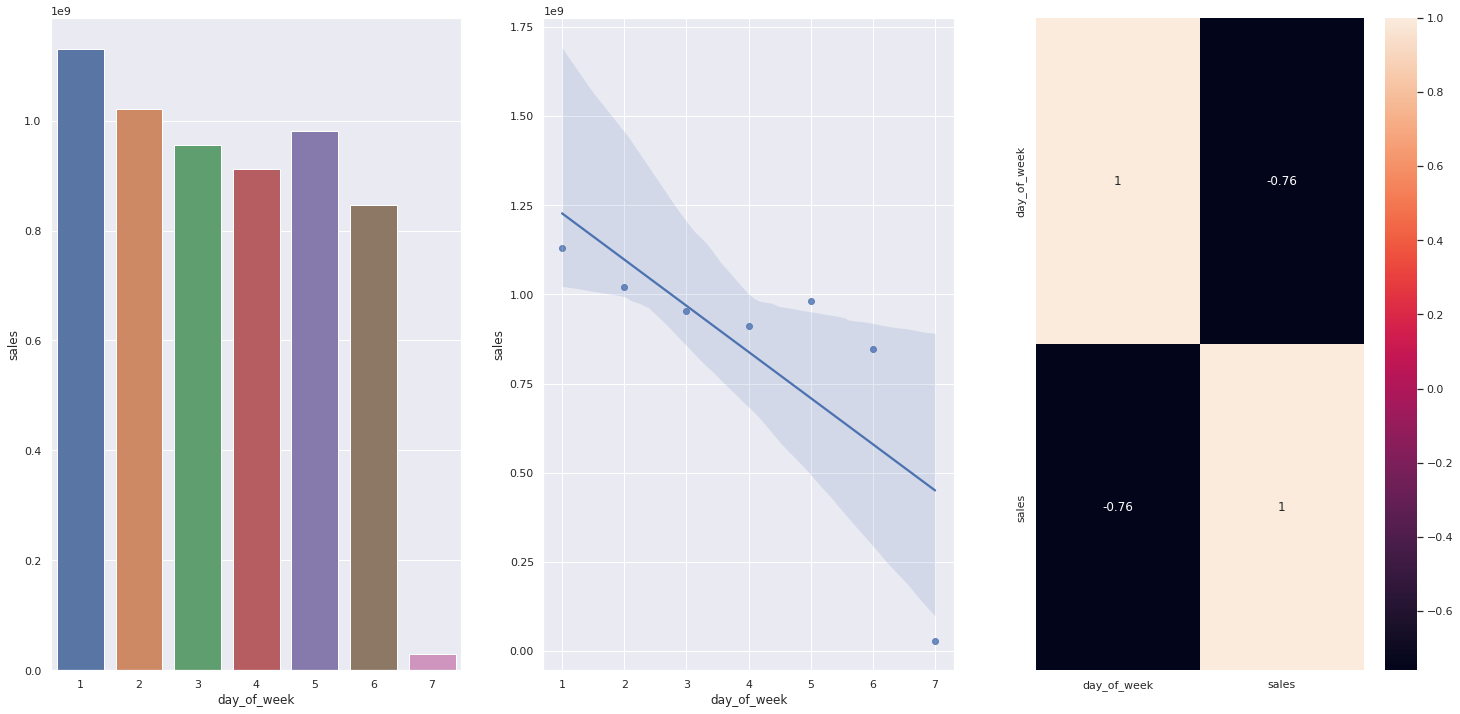

In [35]:
aux1 = df4[[ 'day_of_week', 'sales' ]].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot( x = 'day_of_week', y = 'sales', data = aux1 );

plt.subplot(1, 3, 2)
sns.regplot( x = 'day_of_week', y = 'sales', data = aux1 );

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr( method='pearson' ),annot=True );

### H12. Lojas deveriam vender menos durante os feriados escolares.
* Verdadeira ** As Lojas vendem MENOS durante os feriados escolares, excepet os meses de Julho e Agosto.

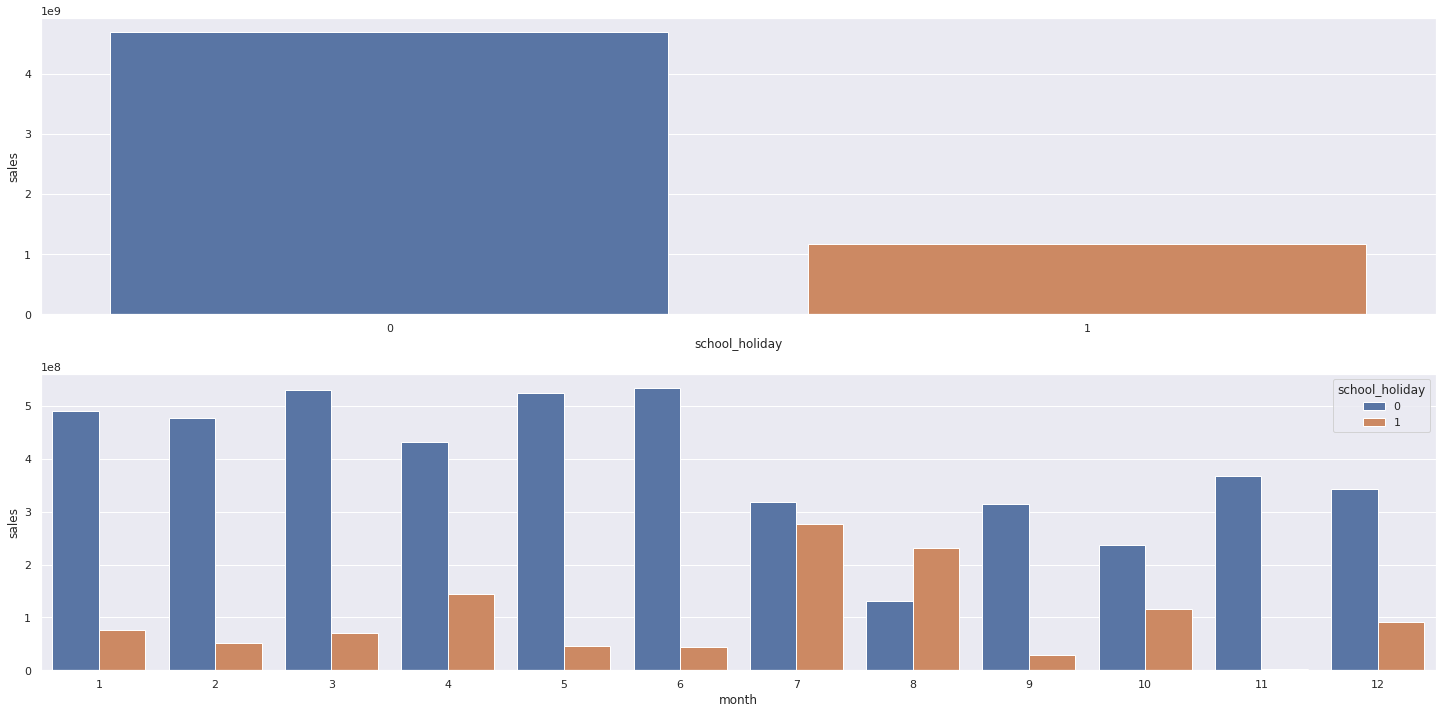

In [36]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2, 1, 1)
sns.barplot( x = 'school_holiday', y = 'sales', data = aux1);

aux2 = df4[['month', 'school_holiday', 'sales']].groupby([ 'month', 'school_holiday']).sum().reset_index()
plt.subplot(2, 1, 2)
sns.barplot( x = 'month', y = 'sales', hue='school_holiday', data = aux2);

### 4.2.1 Resumo das Hipoteses

## 4.3. Analise Multivariada


### 4.3.1. NUmerical attributes

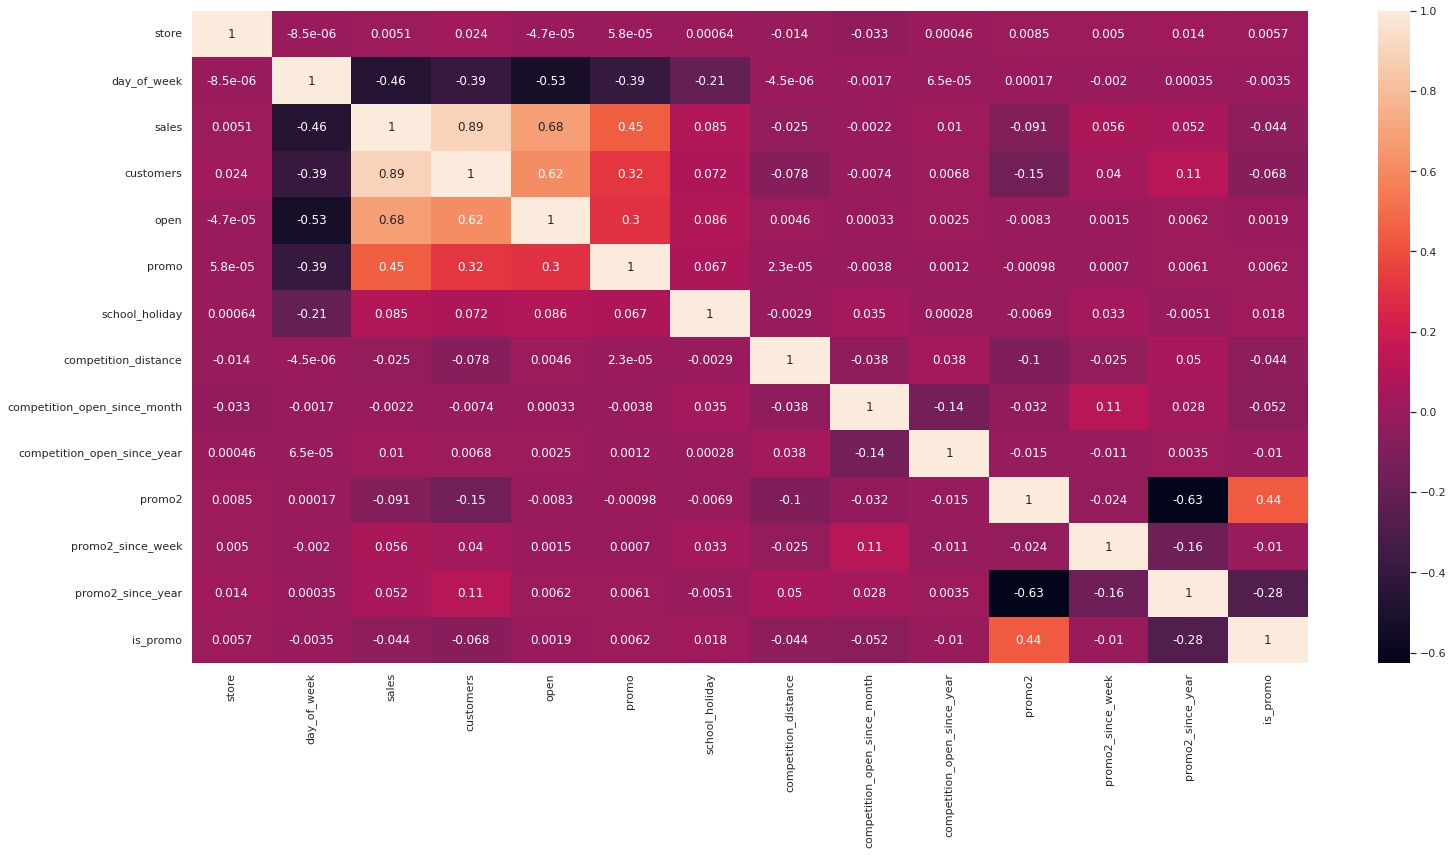

In [37]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );


### 4.3.2. Categorical Attributes

In [40]:
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


<AxesSubplot:>

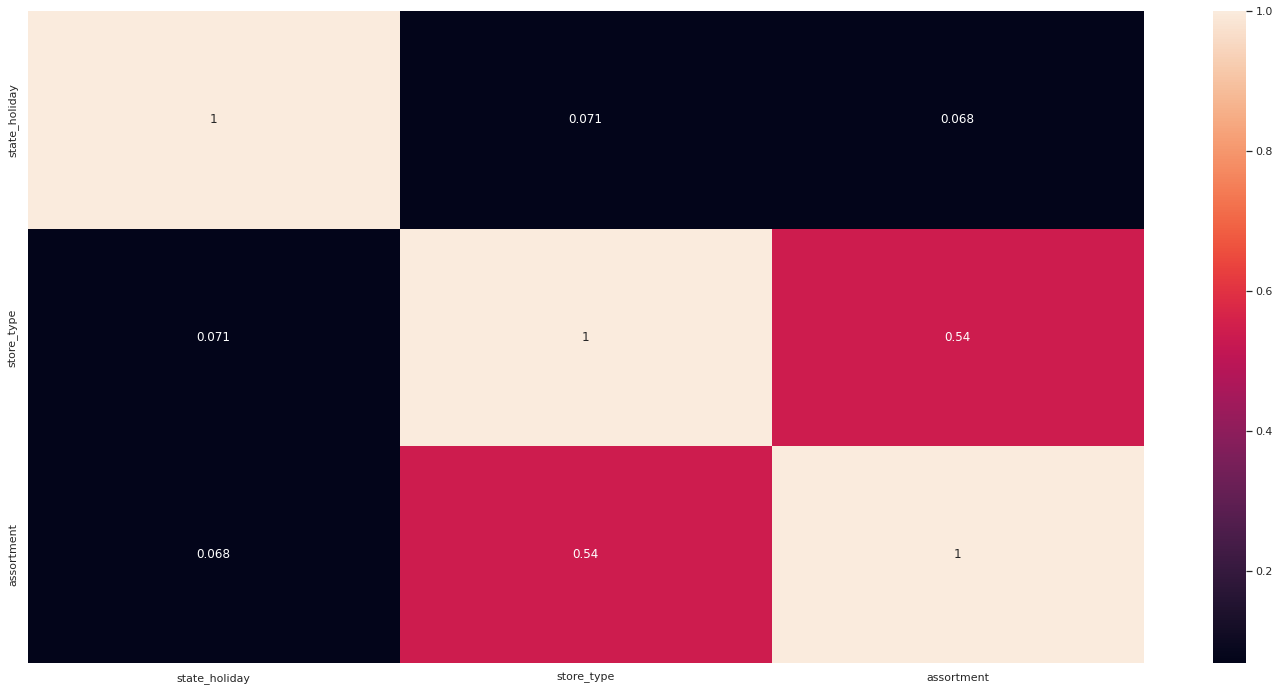

In [39]:
# Only categorical data
a = df4.select_dtypes( include = 'object' )

# Calculate Cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])


a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6], 
               'assortment': [a7, a8, a9] 
              })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True )

# 5.0. PASSO 5 - Preparação dos dados

In [122]:
df5 = df4.copy()

## 5.1. Normalização

## 5.2. Rescaling

In [123]:
a = df5.select_dtypes( include=['int64', 'float64'])

<AxesSubplot:xlabel='competition_distance'>

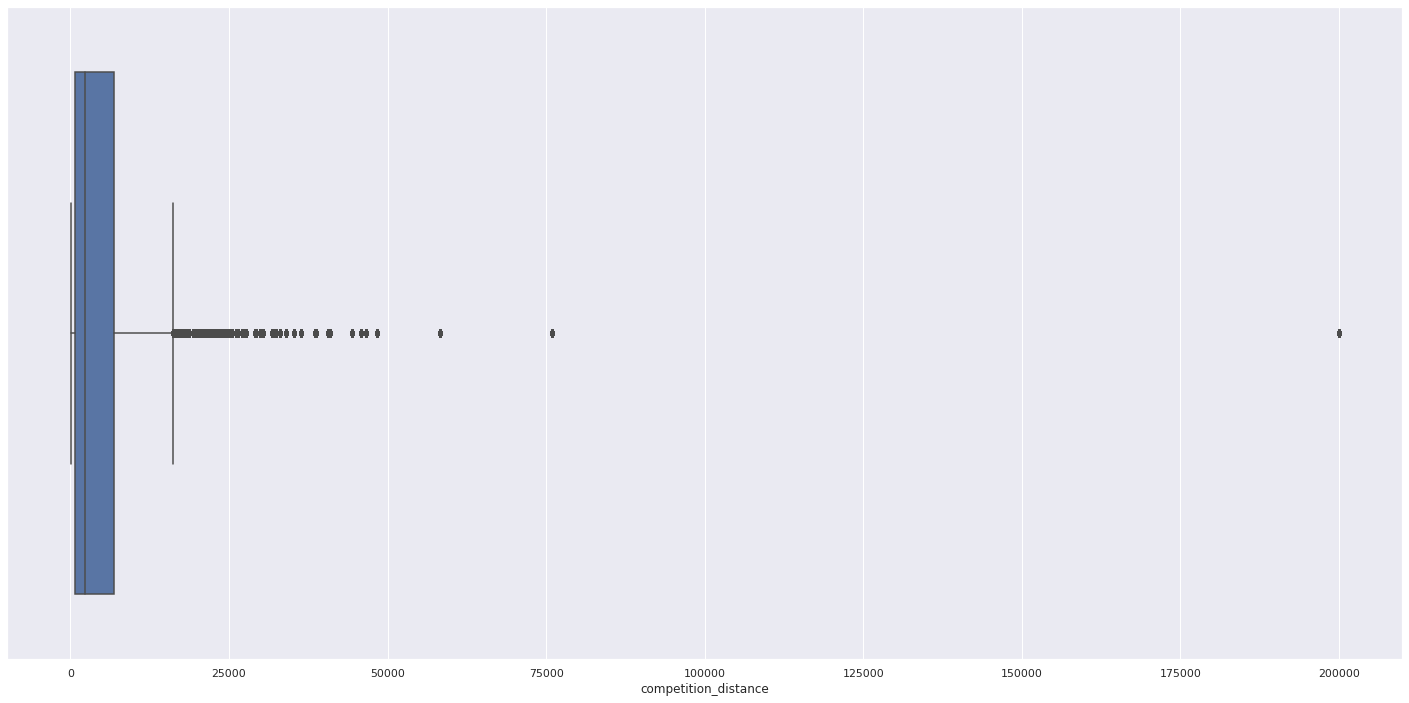

In [124]:
sns.boxplot( df5['competition_distance'])

In [125]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open( 'parameter/competition_distance_scaler.pk1', 'wb' ) )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump( rs, open( 'parameter/competition_time_scaler.pk1', 'wb' ) )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( mms, open( 'parameter/promo_time_week_scaler.pk1', 'wb' ) )

# year
df5['year'] = mms.fit_transform( df5[['year']].values)
pickle.dump( mms, open( 'parameter/year_scaler.pk1', 'wb') )


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

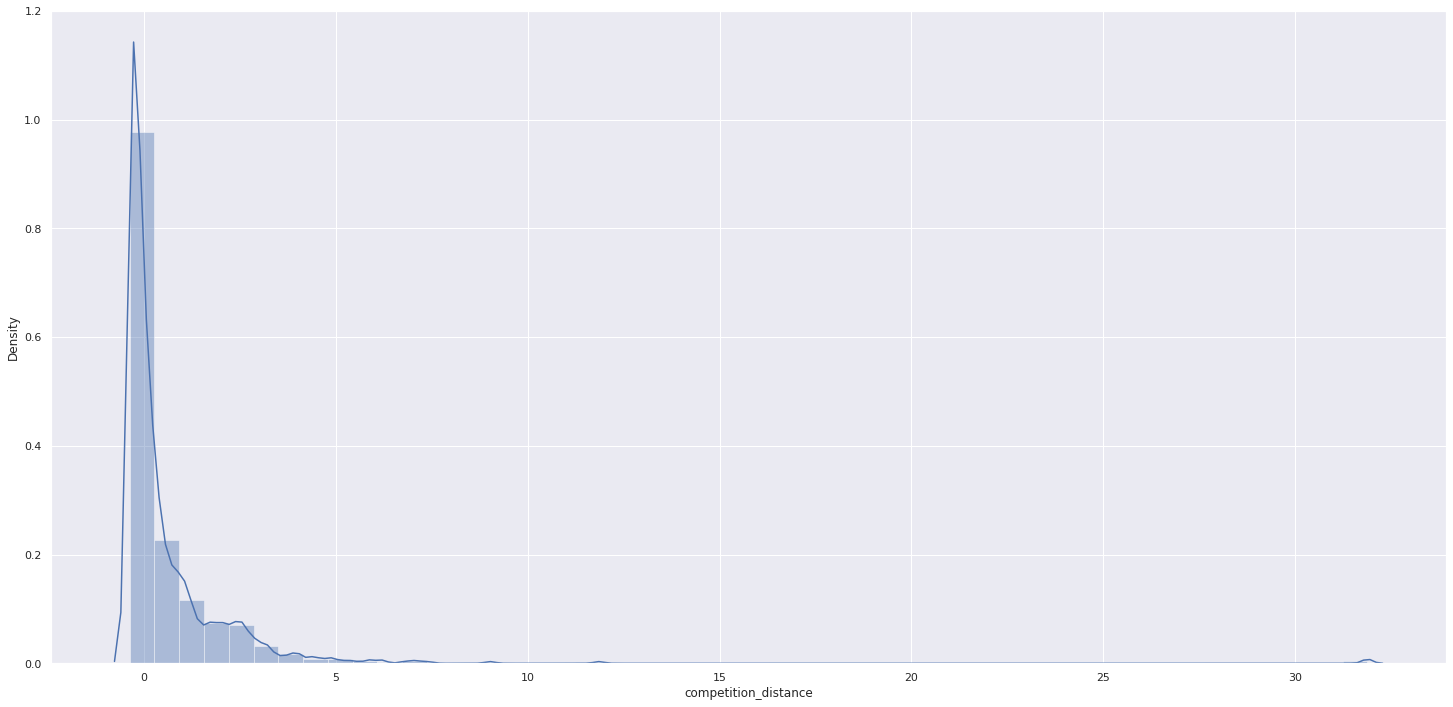

In [126]:
sns.distplot(df5['competition_distance'])

## 5.3. Transformação

### 5.3.1. Encoding

In [127]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( 'parameter/store_type_scaler.pkl', 'wb') )

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2. Response Variable Transformation

In [46]:
df5['sales'] = np.log1p( df5['sales'])

<AxesSubplot:xlabel='sales', ylabel='Density'>

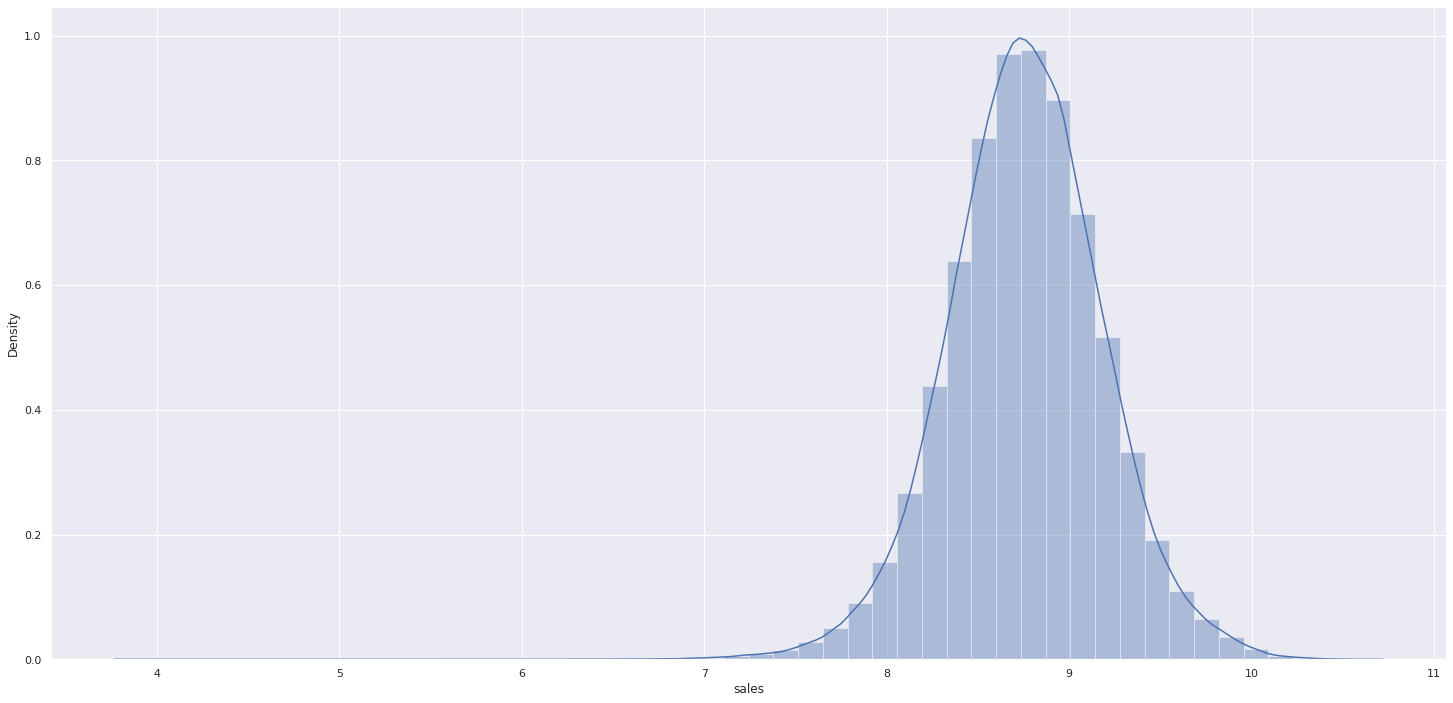

In [57]:
sns.distplot(df5['sales'])

### 5.3.2. Nature Transformation

In [47]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

In [48]:
df5.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,8.568646,8.71029,9.025816,9.546527,8.481151
promo,1,1,1,1,1
school_holiday,1,1,1,1,1
store_type,2,0,0,2,0
assortment,1,1,1,3,1
competition_distance,-0.170968,-0.283871,1.903226,-0.275806,4.448387
competition_open_since_month,9,11,12,9,4


# 6.0. PASSO 6 - Feature selection

In [49]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test datasets

In [50]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1 )

In [51]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days= 6*7 )

Timestamp('2015-06-19 00:00:00')

In [52]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train[ 'date' ].min() ) )
print( 'Training Max Date: {}'.format( X_train[ 'date' ].max() ) )

print( '\nTraining Min Date: {}'.format( X_test[ 'date' ].min() ) )
print( 'Training Max Date: {}'.format( X_test[ 'date' ].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Training Min Date: 2015-06-19 00:00:00
Training Max Date: 2015-07-31 00:00:00


In [53]:
y_test.head().T

0    8.568646
1    8.710290
2    9.025816
3    9.546527
4    8.481151
Name: sales, dtype: float64

## 6.2. Boruta as Feature Selector

In [64]:
# # Training and test dataset for Boruta
# X_train_n = X_train.drop( ['date', 'sales' ], axis=1 ).values
# y_train_n = y_train.values.ravel()

# # Define RandomForestRegressor
# rf = RandomForestRegressor( n_jobs=-1)

# # Define Boruta
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )


### 6.2.1 Best Features from Boruta

In [65]:
# cols_selected = boruta.support_.tolist()


# # best features
# X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# # not selected boruta
# cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

## 6.3. Manual Feature Selection

In [54]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0. PASSO 7 - Machine learning modelling

In [55]:
df7 = df6.copy()

## 7.1.Average Model

In [56]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

In [57]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction
aux2 = aux1[['store', 'sales']].groupby( 'store').mean().reset_index().rename( columns={ 'sales': 'predictions' } )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance

baseline_result = ml_error( 'Average Model', np.expm1(y_test), np.expm1(yhat_baseline) )

baseline_result


,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model

In [58]:
# Model
lr = LinearRegression().fit(x_train, y_train)
    
# Prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression ', np.expm1( y_test ), np.expm1( yhat_lr) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


## 7.2.1. Linear Regression Model - Cross Validation

In [59]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3 Linear Regression Regularized Model - Lasso

In [60]:
# Model
lrr = Lasso( alpha = 0.01 ).fit(x_train, y_train)
    
# Prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression Lasso', np.expm1( y_test ), np.expm1( yhat_lrr) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Lasso,1891.704881,0.289106,2744.451737


## 7.3.1. Linear Regression Regularized Model Lasso - Cross Validation

In [61]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4. Random forest regressor

In [ ]:
# Model
rf = RandomForestRegressor(n_estimators=100,
                           n_jobs=-1,
                           random_state=42 ).fit(x_train, y_train)
    
# Prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf) )
rf_result

### 7.4.1. Random Forest REgressor - Cross Validation 

In [ ]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv

## 7.5. XGBoost Regressor

In [62]:
# Model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror', 
                             n_estimators=100,   # Numero de arvores a ser criada pelo modelo
                             eta=0.01,           # Quantas passadas usa para fazer o aprendizado
                             max_depth=10,       # Maxima profundidade que arvore pode chegar
                             subsample=0.7,      # Qual a porcentagem de todas as variaveis que eu quero fazer uma amostragem
                             colsample_bytee=0.9 # Como se fosse varias arvores para ter um resultado
                             ).fit( x_train, y_train )
    
# Prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,843.112293,0.122609,1250.952637


In [ ]:
### 7.5.1.

In [63]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1030.28 +/- 167.19,0.14 +/- 0.02,1478.26 +/- 229.79


## 7.6. Compare Model's Performance

### 7.6.1. Single Performance

In [64]:
modelling_result = pd.concat( [ baseline_result, lr_result, lrr_result, xgb_result ] )
modelling_result.sort_values('RMSE') # FUNCAO DE ERRRO RMSE

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,843.112293,0.122609,1250.952637
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression Lasso,1891.704881,0.289106,2744.451737


### 7.6.2. Real Performance - Cross Validation

In [65]:
modelling_result_cv = pd.concat( [ lr_result_cv, lrr_result_cv, xgb_result_cv ] ) # Exclui rf_result_cv incluir
modelling_result_cv # FUNCAO DE ERRRO RMSE

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,XGBoost Regressor,1030.28 +/- 167.19,0.14 +/- 0.02,1478.26 +/- 229.79


# 8.0. PASSO 8 - Hiperparameter fine tuning

In [66]:
df8 = df7.copy()

In [67]:
param = {
        'n_estimators'    : [1500, 1700, 2500, 3000, 3500 ],
        'eta'             : [0.01, 0.03],
        'max_depth'       : [3, 5, 9],
        'subsample'       : [0.1, 0.5, 0.7],
        'colsample_bytree' : [0.3, 0.7, 0.9],
        'min_child_weight': [3, 8, 15 ]
        }

MAX_EVAL = 5

In [124]:
# final_result = pd.DataFrame()

# for i in range( MAX_EVAL ):
#     # Choose values for parameters randomly
#     hp = { k: random.sample( v, 1)[0] for k, v in param.items() }
#     print( hp )

#     # Model
#     model_xgb = xgb.XGBRegressor( objective='reg:squarederror', 
#                                  n_estimators = hp['n_estimators'],       # Numero de arvores a ser criada pelo modelo
#                                  eta = hp['eta'],                         # Quantas passadas usa para fazer o aprendizado
#                                  max_depth = hp['max_depth'],             # Maxima profundidade que arvore pode chegar
#                                  subsample = hp['subsample'],             # Qual a porcentagem de todas as variaveis que eu quero fazer uma amostragem
#                                  colsample_bytree = hp['colsample_bytree'], # Como se fosse varias arvores para ter um resultado
#                                  min_child_weight = hp['min_child_weight']# 
#                                 )

#     # performance
#     result = cross_validation( x_training, 5, 'XGBoostRegressor', model_xgb, verbose=False )
#     final_result = pd.concat( [final_result, result] )
    
# final_result    
   

{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 3}
{'n_estimators': 35, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 8}


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoostRegressor,857.26 +/- 118.25,0.12 +/- 0.01,1239.72 +/- 186.12
0,XGBoostRegressor,7346.44 +/- 598.89,1.0 +/- 0.0,8000.11 +/- 698.5


## 8.2. Final Model

In [68]:
param_tuned = {
        'n_estimators'    : 3000, 
        'eta'             : 0.03, 
        'max_depth'       : 5, 
        'subsample'       : 0.7, 
        'colsample_bytree' : 0.7, 
        'min_child_weight': 3 
        }

In [69]:

# Model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror', 
                                     n_estimators = param_tuned['n_estimators'],       # Numero de arvores a ser criada pelo modelo
                                     eta = param_tuned['eta'],                         # Quantas passadas usa para fazer o aprendizado
                                     max_depth = param_tuned['max_depth'],             # Maxima profundidade que arvore pode chegar
                                     subsample = param_tuned['subsample'],             # Qual a porcentagem de todas as variaveis que eu quero fazer uma amostragem
                                     colsample_bytree = param_tuned['colsample_bytree'], # Como se fosse varias arvores para ter um resultado
                                     min_child_weight = param_tuned['min_child_weight'] ).fit( x_train, y_train )

#prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,665.330873,0.097987,958.715745


In [132]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )

In [133]:
mpe

-0.01759492443152097

# 9.0. PASSO 9 - Traducao e interpretacao do erro

In [70]:
df9 = X_test[ cols_selected_boruta_full ]

# Rescale
df9[ 'sales'] = np.expm1(df9['sales'] )
df9[ 'predictions' ] = np.expm1( yhat_xgb_tuned )

## 9.1. Business Performance

In [71]:
# Sum of predictions
df91 = df9[[ 'store', 'predictions']].groupby( 'store').sum().reset_index()

# MAE e MAPE
df9_aux1 = df9[[ 'store', 'sales', 'predictions' ]].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE' } )  
df9_aux2 = df9[[ 'store', 'sales', 'predictions' ]].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'} )

# Merge MAE e MAPE
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge( df91, df9_aux3, how='inner', on='store')

# Scenarios
df92['worst_scenarios'] = df92['predictions'] - df92['MAE'] # Predicao do pior cenario
df92['best_scenarios' ] = df92['predictions'] + df92['MAE'] # Predicao do melhor cenario

# ordem columns
df92 = df92[[ 'store', 'predictions', 'worst_scenarios', 'best_scenarios', 'MAE', 'MAPE' ]] # Ordenacao das colunas


In [168]:
df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenarios,best_scenarios,MAE,MAPE
291,292,108359.789062,104977.608630,111741.969495,3382.180433,0.602768
908,909,220300.078125,212395.141071,228205.015179,7904.937054,0.518675
875,876,194060.812500,189924.534732,198197.090268,4136.277768,0.337730
169,170,201541.687500,200194.421637,202888.953363,1347.265863,0.332923
748,749,206800.953125,205789.192013,207812.714237,1011.761112,0.283049


<AxesSubplot:xlabel='store', ylabel='MAPE'>

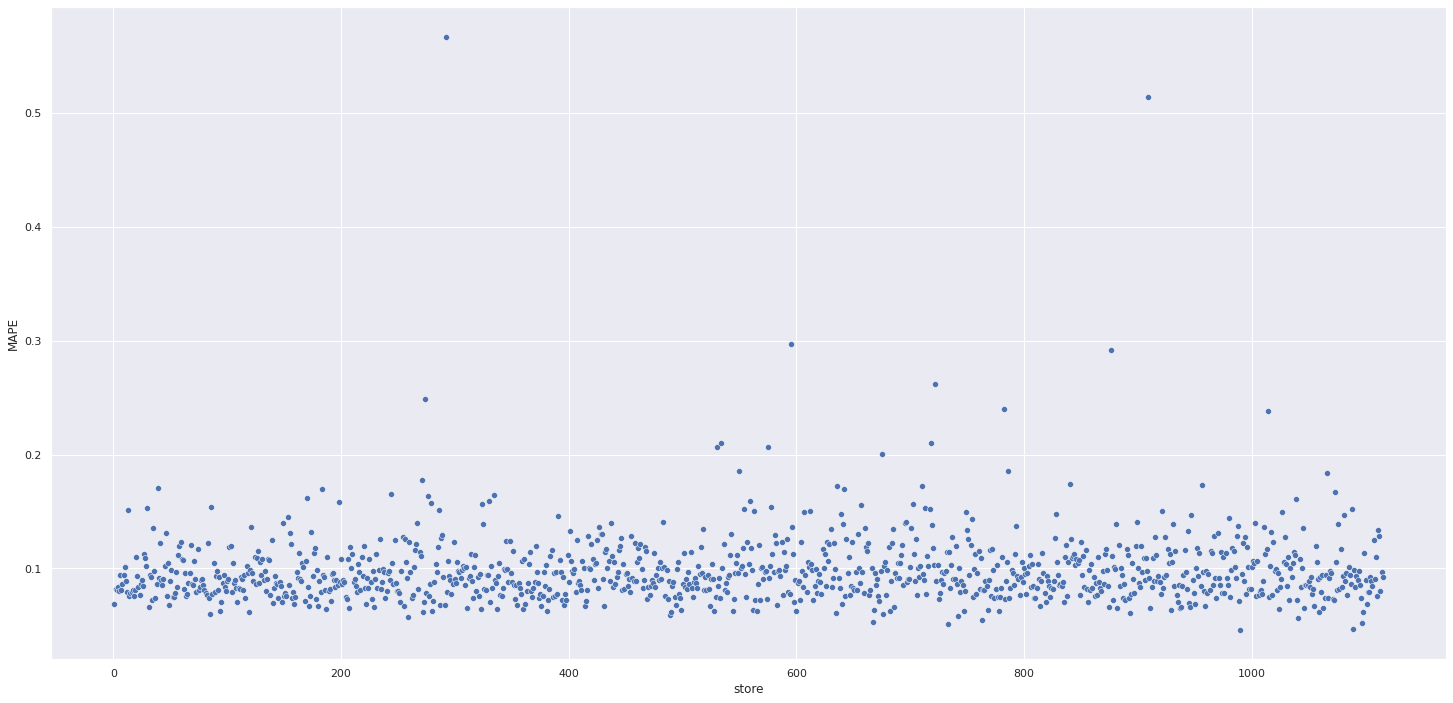

In [72]:
sns.scatterplot( x='store', y='MAPE', data=df92) # Visualizacao das lojas com MAPE mais alto e mais baixo

## 9.2. Total Performance

In [73]:
# forma de mostrar o valor real - 
df93 = df92[[ 'predictions', 'worst_scenarios', 'best_scenarios']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenarios', 0: 'Values' } )
df93[ 'Values'] = df93[ 'Values' ].map( 'R$ {:,.2f}'.format )
df93.head()



,Scenarios,Values
0,predictions,"R$ 286,922,304.00"
1,worst_scenarios,"R$ 286,176,354.10"
2,best_scenarios,"R$ 287,668,215.25"


## 9.3. Machine Learning Performance

In [9]:
# Visualizando a performance do modelo

df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

NameError: name 'df9' is not defined

<AxesSubplot:xlabel='predictions', ylabel='error'>

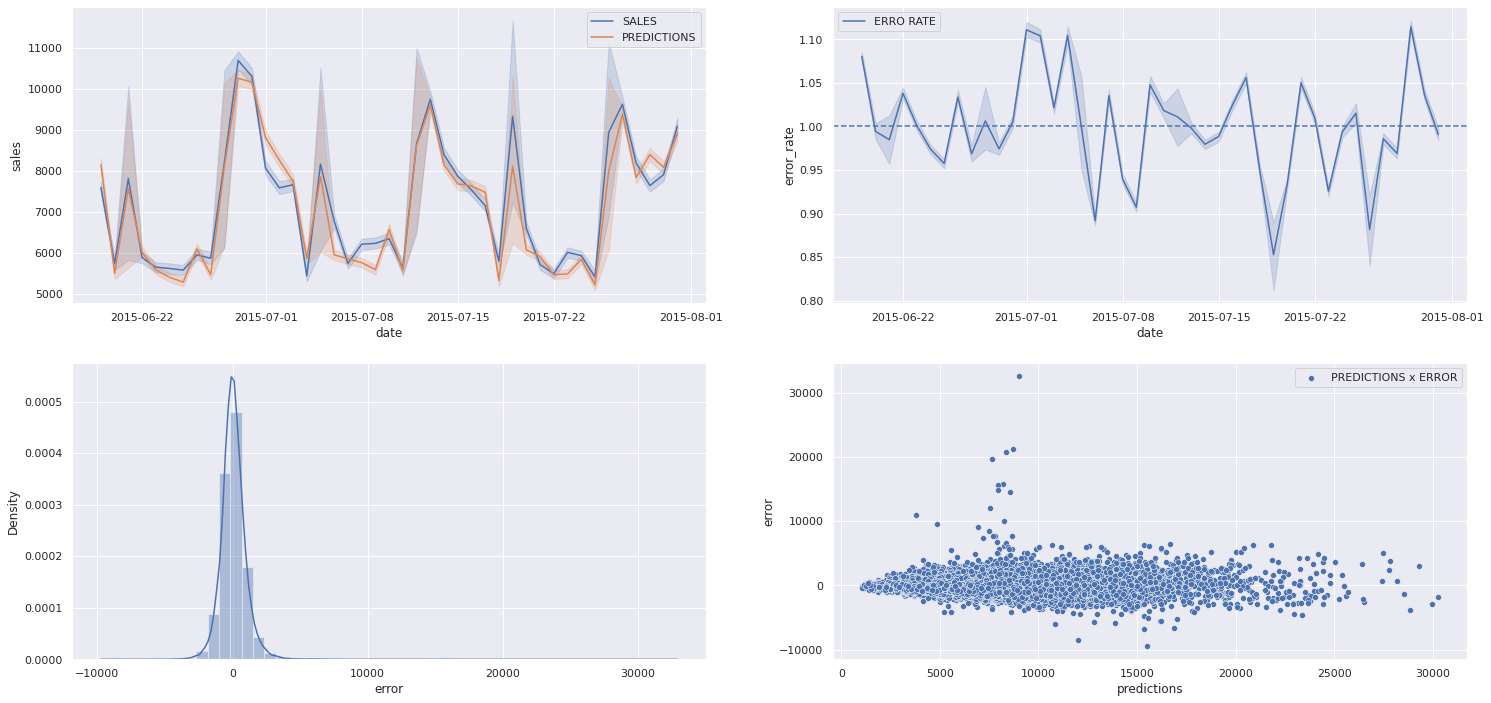

In [75]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES')
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9, label='ERRO RATE')
plt.axhline( 1, linestyle='--' ) # Se a variacao for acima do 1, entao eu tenho uma superextimacao,
                                 # Se for abaixo do 1, entao significa que as minhas predicoes sao menores que as vendas

plt.subplot( 2, 2, 3)
sns.distplot( df9['error'], label='ERROR') # Fala da distribuicao do erro, foi pego todos os erros que o modelo gerou.
                                           # Distribuicao proxima da Clausiana
                                           # Grafico muito usado em analise de residuos 
plt.subplot( 2, 2, 4)
sns.scatterplot( df9['predictions'], df9['error'], label='PREDICTIONS x ERROR' )
#  Grafico de analise de residuos, são as prediçõe em relação ao erro
#  Que sempre as previsões entre 8000 e 10000 sempre tem os erros maiores
#  Quanto maior o valor das previsões maior o erro
                                 

# 10.0 PASSO 10 - Deploy Model to production

In [8]:
# Save Trained Model
pickle.dump( model_xgb_tuned, open( 'model/model_rossmann.pk1', 'wb') )

NameError: name 'model_xgb_tuned' is not defined

## 10.1. Rossmann Class

In [96]:
import pickle

class Rossmann( object ):
    def __init__( self ):
        sefl.home_path='/home/clever/repos/ds_producao'
        seft.competition_distance_scaler   = pickle.load( open( 'parameter/competition_distance_scaler.pk1', 'rb' ) )
        self.competition_time_month_scaler = pickle.load( open( 'parameter/competition_time_month_scaler.pk1', 'rb' ) )
        self.promo_time_week_scaler        = pickle.load( open( 'parameter/promo_time_week_scaler.pk1', 'rb' ) )
        self.year_scaler                   = pickle.load( open( 'parameter/year_scaler.pk1', 'rb') )
        self.store_type_scaler             = pickle.load( open( 'parameter/store_type_scaler.pw1', 'rb'))

    def data_cleaning( seft, df1 ):    
        

        cols_old = ['Store',
                    'DayOfWeek',
                    'Date',
                    'Sales', 
                    'Customers',
                    'Open',
                    'Promo',
                    'StateHoliday',
                    'SchoolHoliday',
                    'StoreType',
                    'Assortment',
                    'CompetitionDistance',
                    'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear',
                    'Promo2',
                    'Promo2SinceWeek',
                    'Promo2SinceYear',
                    'PromoInterval' ]

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        # rename
        df1.columns = cols_new

        ## 1.3. Data types

        df1['date'] = pd.to_datetime( df1['date'] ) # Transformacao do tipo da coluna - No caso 'Date'

        ## 1.5. Fillout NA

        # Removendo NA usando lambda

        # competition_distance
        df1[ 'competition_distance' ] = df1[ 'competition_distance' ].apply( lambda x: 200000.0 if math.isnan( x ) else x )
        # competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis=1 )
        # competition_open_since_year
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'], axis=1 )
        # promo2_since_week             
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'], axis=1 )
        # promo2_since_year         
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'], axis=1 )
        # promo_interval


        # Criando uma Coluna Mes, e substituindo NA por 0
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dez'}

        df1['promo_interval'].fillna(0, inplace=True ) #Foi substituido NA por 0, nao retornando nenhum valor

        df1['month_map'] = df1['date'].dt.month.map( month_map ) #Transforma em data / mes / depois substitui os numeros por letras

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1 )


        ## 1.6. Change Types

        # Modificando o tipo dos dados por colunas
        #Competition
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year' ] = df1['competition_open_since_year' ].astype(int)

        # Promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        
        return df1


    def feature_engineering( self, df2 ):
        

        #year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week

        # week year
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )


        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days ).astype(int)

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = (( df2['date'] - df2['promo_since']) /7).apply( lambda x: x.days ).astype( int )

        # assortment
        # a = basic, b = extra, c = extended
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # state holiday
        # a = public_holiday, b = easter_holiday, c = christmas
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')



        # 3.0. PASSO 3 - Filtragem de variaveis

        ## 3.1. Filtragem das linhas
        df2 = df2[(df2['open'] != 0) & (df2['sales'] > 0)]

        ## 3.2. Selecao das colunas
        cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2

    def data_preparation( seft, df5 ):
        
        ## 5.2. Rescaling


        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )

        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )
        
        # promo time week
        df5['promo_time_week'] = self.promo_time_week.fit_transform( df5[['promo_time_week']].values )
        
        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year_scaler']].values)

        ### 5.3.1. Encoding

        # state_holiday - type - One HoT Encoding 
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # Store_type - Label_Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'])
        
        # assortment - 
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        ### 5.3.2. Response Variable Transformation

        df5['sales'] = np.log1p( df5['sales'])

        sns.distplot(df5['sales'])

        ### 5.3.2. Nature Transformation

        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
        cols_selected = [
                        'store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'month_sin',
                        'month_cos',
                        'day_sin',
                        'day_cos',
                        'week_of_year_sin',
                        'week_of_year_cos']

        return df5[ cols_selected ] 

## 10.2. API Handler

In [111]:
import pickle
import pandas as pd

from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann


# Loading Model
model = pickle.load( open( 'model/model_rossmann.pk1', 'rb') )

# initialize API
app = Flask( __name__ )

@app.route( '/rossman/predict', methods=[ 'POST' ] )
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )   
        
        return df_response
        
    else:
        return Response( '{}', status = 200, mimetype='application/json' )
    
if __name__ == '__main__':
    app.run( '0.0.0.0' )

ModuleNotFoundError: No module named 'rossmann'

## 10.3. API Tester

In [4]:
import requests

In [5]:
df10 = pd.read_csv( 'datasets/test.csv' )

In [6]:
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# Choose store for prediction
df_test = df_test[df_test['Store'] == 22 ]

# remove closed days
df_test = df_test[df_test['Open'] != 0 ]
df_test = df_test[~df_test['Open'].isnull() ]
df_test = df_test.drop( 'Id', axis=1 )



NameError: name 'df_store_raw' is not defined

In [7]:
# convert DataFrame to Json
data = json.dumps( df_test.to_dict( orient='records' ) )

NameError: name 'df_test' is not defined

In [3]:
# API call
# url = 'http://0.0.0.0:5000/rossmann/predict'
url = 'https://model-rossmann-store.herokuapp.com/rossmann/predict'

header = { 'Content-type': 'application/json' }
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code{}'.format( r.status_code) )

NameError: name 'data' is not defined

ola mundo
